In [1]:
import fermat as F
import numpy as np
from scipy.spatial import  distance_matrix
from sklearn.manifold import TSNE
from scipy.optimize import minimize
from sklearn.neighbors import KDTree
from scipy.optimize import LinearConstraint


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

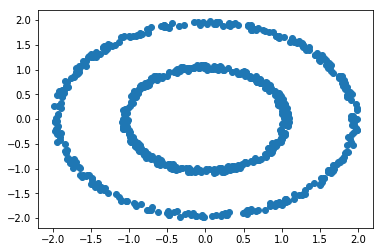

In [2]:
#CREO DOS CIRCULOS DE DATA PEGADOS
k=2


X=np.zeros((700,2))
angulos1=np.random.random_sample(X.shape[0]//2)*2*np.pi
angulos2=np.random.random_sample(X.shape[0]//2)*2*np.pi
radio1=1+0.1*np.random.random_sample(X.shape[0]//2)
radio2=1.9+0.1*np.random.random_sample(X.shape[0]//2)
X[:X.shape[0]//2,:]=[[np.cos(angulos1[i])*radio1[i],np.sin(angulos1[i])*radio1[i]] for i in range(X.shape[0]//2)]
X[X.shape[0]//2:,:]=[[np.cos(angulos2[i])*radio2[i],np.sin(angulos2[i])*radio2[i]] for i in range(X.shape[0]//2)]

plt.scatter(X[:,0],X[:,1])

In [3]:
alpha=4
k=30
landmarks=2

In [4]:
%%time
model=F.Fermat(alpha=alpha,k=k,landmarks=landmarks, path_method='L')
model.fit(np.matrix(distance_matrix(X,X)))
dist=model.get_distances()

CPU times: user 29.2 s, sys: 84 ms, total: 29.3 s
Wall time: 29.6 s


In [5]:
%%time
model=F.Fermat(alpha=alpha,k=k, path_method='D')
model.fit(np.matrix(distance_matrix(X,X)))
dist=model.get_distances()

CPU times: user 2.39 s, sys: 52 ms, total: 2.44 s
Wall time: 2.44 s


In [6]:
%%time
model=F.Fermat(alpha=alpha,k=k,landmarks=landmarks, path_method='FW')
model.fit(np.matrix(distance_matrix(X,X)))
dist=model.get_distances()

CPU times: user 7.41 s, sys: 84 ms, total: 7.49 s
Wall time: 7.46 s


In [7]:
tsne_model = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=500)
tsnes = tsne_model.fit_transform(dist)

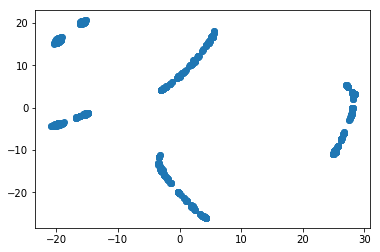

In [8]:
plt.scatter(tsnes[:,0],tsnes[:,1])

In [9]:
dist[0,-1]

0.41684460725494443

In [10]:
dist[0,1]

0.0006521230993135502

In [11]:
dist[0,125]

1.0823706864051131e-05

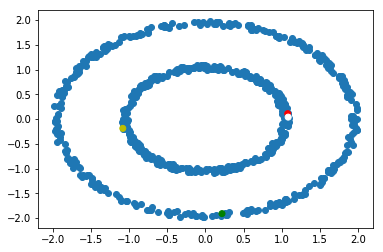

In [12]:

plt.scatter(X[:,0],X[:,1])
plt.scatter(X[[0,1,-1,125],0],X[[0,1,-1,125],1], c=['r','y','g','w'])

# Arranca otra cosa aca, probemos un poco a ver que sale de transporte o de minimizar con restriccion


## Arrancamos probando si los x transportados los incluyo en la superficie, FALLA

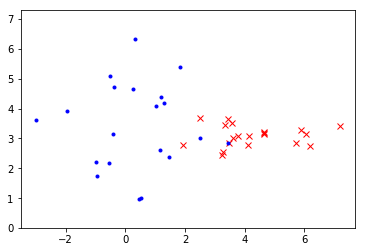

In [13]:
puntos=20
#Z son los iniciales
#Y son los objetivo
#x son los Z transformados, lo que voy a optimizar


y1, y2 = np.random.multivariate_normal([1,3], [[3,0],[0,3]], puntos).T
y1=np.array(y1)
y2=np.array(y2)
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)

Ycol=np.concatenate((y1,y2),axis=1)
Y=np.concatenate((y1,y2),axis=0)


x1, x2 = np.random.multivariate_normal([4,3], [[2,0.2],[0.2,0.2]], puntos).T
x1=np.array(x1)
x2=np.array(x2)
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)
Z=np.concatenate((x1,x2),axis=0)
Zcol=np.concatenate((x1,x2),axis=1)


plt.axis('equal')
plt.plot(x1,x2,'x',c='r')
plt.plot(y1,y2,'.',c='b')

In [14]:
#Esta funcion hace fermat con TODOS los puntos,x(los que optimizo) +z (inicio)+y (objetivo)
def costo(x):
    alpha=2

    
    xposta=x.reshape(2,x.shape[0]//2).T
    
    data=np.concatenate((Zcol,Ycol),axis=0)
    data=np.concatenate((data,xposta),axis=0)
    distancias=np.matrix(distance_matrix(data,data))
    
    k=10
    model=F.Fermat(alpha, path_method='FW',k=k)
    model.fit(distancias)
    dist=model.get_distances()
    
    res=0
    for i in range(Zcol.shape[0]):
        res+=dist[i,2*puntos+i]    
    
    return res


def costo_euclideo(x):
    xposta=x.reshape(2,x.shape[0]//2).T
    res=0
    for i in range(Zcol.shape[0]):
        res+=np.linalg.norm(Zcol[i]-xposta[i])   
    return res
    

In [15]:
aux=np.ones(puntos)
A=np.zeros((2,2*puntos))
A.shape
A[0,:puntos]=aux
A[1,puntos:]=aux
A=A/puntos
b=np.mean(Ycol,axis=0)


#RESTRICCIONES DE IGUALDAD
con1 = lambda x: np.dot(A[1,:], x) - b[1]
con0 = lambda x: np.dot(A[0,:], x ) - b[0]
#CONSTRAINTS
cons = [{'type': 'eq', 'fun': con0},{'type': 'eq', 'fun': con1} ]

#XINICIAL
xinit = Y


#ACA PUEDO PONER OPCIONES
opt={"disp": True}

In [16]:
%%time
res = minimize(costo, x0=xinit, constraints=cons,options=opt)
print(res)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 46.23201855562671
            Iterations: 58
            Function evaluations: 2512
            Gradient evaluations: 58
     fun: 46.23201855562671
     jac: array([-0.43489122, -0.43421698, -0.43598318, -0.43493891, -0.43513393,
       -0.43503571, -0.43480015, -0.43468809, -0.43450308, -0.43477058,
       -0.43499517, -0.43546152, -0.43498993, -0.4353385 , -0.43473625,
       -0.43488598, -0.43557024, -0.43486452, -0.43434715, -0.43520689,
       -0.1528573 , -0.15255213, -0.15162468, -0.15288019, -0.15328979,
       -0.15367556, -0.15314674, -0.15258074, -0.15241432, -0.15297508,
       -0.15298939, -0.15262127, -0.15331078, -0.15307903, -0.15262222,
       -0.15204668, -0.15274429, -0.15289211, -0.15417194, -0.15294075])
 message: 'Optimization terminated successfully.'
    nfev: 2512
     nit: 58
    njev: 58
  status: 0
 success: True
       x: array([-1.20042978,  0.04111369,  0.76385515,

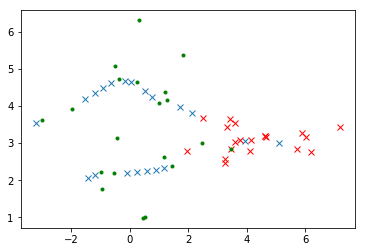

In [17]:
X_transported=res['x']

x=X_transported[:X_transported.shape[0]//2]
y=X_transported[X_transported.shape[0]//2:]
plt.plot(x,y,'x')

plt.plot(x1,x2,'x',c='r')
plt.plot(y1,y2,'.',c='g')


## Probando aca si no incluyo los puntos transportados 

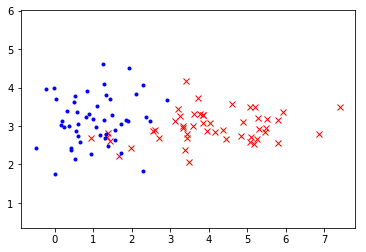

In [18]:
puntos=50
#Z son los iniciales
#Y son los objetivo
#x son los Z transformados, lo que voy a optimizar

y1, y2 = np.random.multivariate_normal([1,3], [[0.5,0],[0,0.5]], puntos).T
y1=np.array(y1)
y2=np.array(y2)
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)

Ycol=np.concatenate((y1,y2),axis=1)
Y=np.concatenate((y1,y2),axis=0)
np.random.shuffle(Ycol)


x1, x2 = np.random.multivariate_normal([4,3], [[2,0.2],[0.2,0.2]], puntos).T
x1=np.array(x1)
x2=np.array(x2)
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)
Z=np.concatenate((x1,x2),axis=0)
Zcol=np.concatenate((x1,x2),axis=1)
np.random.shuffle(Zcol)


plt.axis('equal')
plt.plot(x1,x2,'x',c='r')
plt.plot(y1,y2,'.',c='b')

In [19]:
alphaESP=2
kESP=5#cuanos vecinos miro para decidir la distancia a la que esta el nuevo punto
        
dataESP=np.concatenate((Zcol,Ycol),axis=0)
distanciasESP=np.matrix(distance_matrix(dataESP,dataESP))

modelESP=F.Fermat(alphaESP, path_method='FW')
modelESP.fit(distanciasESP)
distESP=modelESP.get_distances()
treeESP = KDTree(dataESP, leaf_size=2)

def costo_sin_x(x):
    
    xposta=x.reshape(2,x.shape[0]//2).T
     
    res=0
    gradient=np.ones(x.shape)
    for i in range(Zcol.shape[0]):
        aux,grad_idx=distanciaFermat(i,xposta[i,:],distESP,treeESP,kESP) 
        res+=aux
        
        q=dataESP[grad_idx,:] #el ultimo mas cercano en el "mejor camino"
        grad=alphaESP*(np.linalg.norm(q-xposta[i,:])**(alphaESP-2))*(xposta[i,:]-q) #EL gradiente
        
        gradient[i]=grad[0]
        gradient[puntos+i]=grad[1]
    return res,gradient



def distanciaFermat(idx,end,dist,tree,k):
    d,ind=tree.query([end],k=k)
    d=np.power(d,alphaESP)
    ret=min([ dist[idx,ind[0,i]]+d[0,i] for i in range(d.shape[1])])
    
    indice=np.argmin([ dist[idx,ind[0,i]] for i in range(ind.shape[1])]) 
    
    grad_idx=ind[0,indice] #DEVUELVE EL INDICE DEL VECINO que esta a menor dist_fer de idx
    
    return ret,grad_idx



def costo_sin_x_ni_grad(x):
    
    xposta=x.reshape(2,x.shape[0]//2).T
     
    res=0
    for i in range(Zcol.shape[0]):
        aux,grad_idx=distanciaFermat(i,xposta[i,:],distESP,treeESP,kESP) 
        res+=aux
    return res

In [20]:
aux=np.ones(puntos)
A=np.zeros((2,2*puntos))
A.shape
A[0,:puntos]=aux
A[1,puntos:]=aux
A=A/puntos
b=np.mean(Ycol,axis=0)

#RESTRICCIONES DE IGUALDAD, NO LAS USO
con1 = lambda x: np.dot(A[1,:], x) - b[1]
con0 = lambda x: np.dot(A[0,:], x ) - b[0]
cons = [{'type': 'eq', 'fun': con0},{'type': 'eq', 'fun': con1} ]


#LINEAR CONSTRAINTS (YA SEGURO INCLUYE JAC Y TODO)
#eps=0.1*np.ones(b.shape)
#cons = LinearConstraint(A,b-eps,b+eps)
cons=LinearConstraint(A,b,b)

#XINICIAL, QUE VA
xinit = Y

#ACA PUEDO PONER OPCIONES
opt={"disp": True}

#### Probando sin darle el gradiente

In [21]:
%%time
res = minimize(costo_sin_x_ni_grad, x0=xinit, constraints=cons,options=opt)
print(res)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 58.46163892281452
            Iterations: 18
            Function evaluations: 1842
            Gradient evaluations: 18
     fun: 58.46163892281452
     jac: array([-0.25482655, -0.25518513, -0.25494671, -0.25497723, -0.25486469,
       -0.25485802, -0.25485516, -0.25482559, -0.25494003, -0.25489807,
       -0.25480747, -0.25485611, -0.25520897, -0.25496292, -0.25513363,
       -0.25509739, -0.25495148, -0.25497246, -0.25485325, -0.25497055,
       -0.25513554, -0.25491905, -0.25494862, -0.25458336, -0.25515556,
       -0.25479317, -0.25546455, -0.25494194, -0.25455952, -0.25487137,
       -0.25484753, -0.2548914 , -0.25490236, -0.25486279, -0.25475216,
       -0.25484228, -0.2549119 , -0.25492716, -0.25489092, -0.25501156,
       -0.25491667, -0.25495672, -0.25511503, -0.2547574 , -0.25503969,
       -0.25485754, -0.25491762, -0.25492239, -0.25503397, -0.25497007,
        0.08538437,  0.0853891

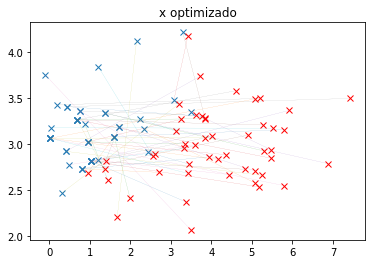

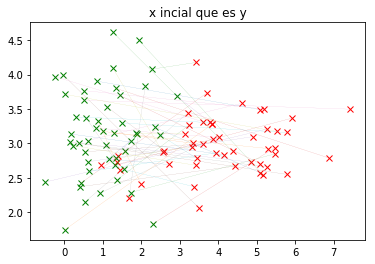

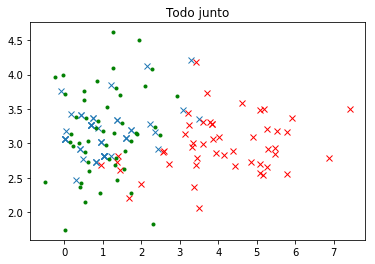

In [22]:
X_transported=res['x']

x=X_transported[:X_transported.shape[0]//2]
y=X_transported[X_transported.shape[0]//2:]

plt.plot(x,y,'x')
plt.plot(x1,x2,'x',c='r')
#plt.plot(y1,y2,'.',c='g')
for i in range(len(x)):
    plt.plot([x1[i],x[i]],[x2[i],y[i]],lw=0.1)
plt.title('x optimizado')
plt.show()
#plt.plot([2,1],[4,4])


plt.plot(x1,x2,'x',c='r')
plt.plot(y1,y2,'x',c='g')
for i in range(len(x)):
    plt.plot([x1[i],y1[i]],[x2[i],y2[i]],lw=0.1)

plt.title('x incial que es y')
plt.show()



plt.plot(x,y,'x')
plt.plot(x1,x2,'x',c='r')
plt.plot(y1,y2,'.',c='g')
plt.title('Todo junto')
plt.show()

#### Probando CON el gradiente

In [23]:
aux=np.ones(puntos)
A=np.zeros((2,2*puntos))
A.shape
A[0,:puntos]=aux
A[1,puntos:]=aux
A=A/puntos
b=np.mean(Ycol,axis=0)

#RESTRICCIONES DE IGUALDAD
con1 = lambda x: np.dot(A[1,:], x) - b[1]
con0 = lambda x: np.dot(A[0,:], x ) - b[0]
#cons = [{'type': 'eq', 'fun': con0},{'type': 'eq', 'fun': con1} ]


#LINEAR CONSTRAINTS
#eps=0.1*np.ones(b.shape)
#cons = LinearConstraint(A,b-eps,b+eps)
cons=LinearConstraint(A,b,b)

#XINICIAL, QUE VA
xinit = Y

#ACA PUEDO PONER OPCIONES
opt={"disp": True}

In [24]:
%%time

res = minimize(costo_sin_x, x0=xinit,jac=True, constraints=cons,options=opt)
print(res)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 58.77580479885596
            Iterations: 7
            Function evaluations: 21
            Gradient evaluations: 7
     fun: 58.77580479885596
     jac: array([-0.44161257, -0.43844047, -0.43532746, -0.43811371, -0.44544847,
       -0.44209939, -0.44991937, -0.44244098, -0.44280647, -0.44456057,
       -0.44867474, -0.44576865, -0.45225049, -0.48645002, -0.45169157,
       -0.43752666, -0.44351192, -0.4451347 , -0.44428083, -0.45335294,
       -0.43373747, -0.44721217, -0.43566359, -0.44510743, -0.43518254,
       -0.45967943, -0.44041397, -0.47621742, -0.44871168, -0.44467565,
       -0.44410434, -0.44452893, -0.44024101, -0.432015  , -0.44666234,
       -0.44595957, -0.44291785, -0.44511205, -0.43873455, -0.4424396 ,
       -0.44355758, -0.46873257, -0.451885  , -0.46830421, -0.45030072,
       -0.44304627, -0.44277769, -0.44626907, -0.44887542, -0.43926001,
        0.17725479,  0.17865409,  

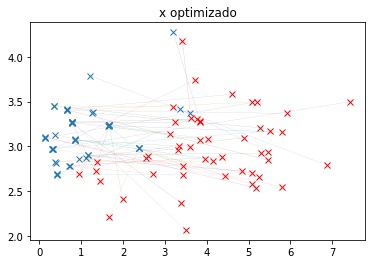

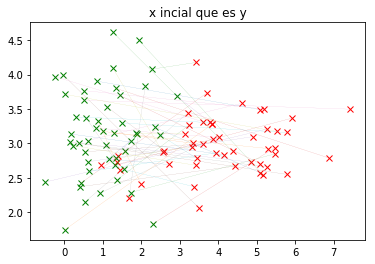

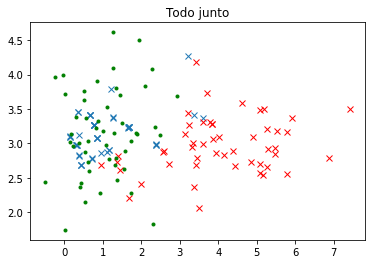

In [25]:
X_transported=res['x']

x=X_transported[:X_transported.shape[0]//2]
y=X_transported[X_transported.shape[0]//2:]

plt.plot(x,y,'x')
plt.plot(x1,x2,'x',c='r')
#plt.plot(y1,y2,'.',c='g')
for i in range(len(x)):
    plt.plot([x1[i],x[i]],[x2[i],y[i]],lw=0.1)
plt.title('x optimizado')
plt.show()
#plt.plot([2,1],[4,4])


plt.plot(x1,x2,'x',c='r')
plt.plot(y1,y2,'x',c='g')
for i in range(len(x)):
    plt.plot([x1[i],y1[i]],[x2[i],y2[i]],lw=0.1)

plt.title('x incial que es y')
plt.show()



plt.plot(x,y,'x')
plt.plot(x1,x2,'x',c='r')
plt.plot(y1,y2,'.',c='g')
plt.title('Todo junto')
plt.show()

## HACER LO MISMO CON SIWSS ROLL, parece caminar (con un poco de cariño)

In [26]:
from generate_data import generate_swiss_roll

data, labels = generate_swiss_roll(oscilations = 7, A = 10, n = 100)

for i in range(len(labels)):
    if labels[i]==1: 
        labels[i]=0
    if labels[i]==3:
        labels[i]=2

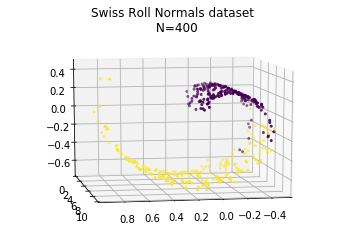

In [27]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 80)
ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2], c=labels, s=4)
plt.title('Swiss Roll Normals dataset \n N=%s'%(data.shape[0]))

plt.show()

In [28]:
Z=np.zeros((data.shape[0]//2,data.shape[1]))
Y=np.zeros((data.shape[0]//2,data.shape[1]))

half=data.shape[0]//2
for i in range(data.shape[0]):
    if i<half:
        Z[i,:]=data[i,:]
    else:
        Y[i-half,:]=data[i,:]

In [29]:
#OJO ACA GUARDO COMO X,Y,Z,XYZ NO XXXYYYZZZ
np.random.shuffle(Y)
Ycol=Y
Y=Y.flatten()

np.random.shuffle(Z)
Zcol=Z
Z=Z.flatten()


dimension=3
puntos=data.shape[0]//2

In [37]:
alphaESP=3
kESP=5#cuanos vecinos miro para decidir la distancia a la que esta el nuevo punto
        
dataESP=np.concatenate((Zcol,Ycol),axis=0)
distanciasESP=np.matrix(distance_matrix(dataESP,dataESP))

modelESP=F.Fermat(alphaESP, path_method='FW')
modelESP.fit(distanciasESP)
distESP=modelESP.get_distances()
treeESP = KDTree(dataESP, leaf_size=2)

def costo_sin_x(x):
    
    xposta=x.reshape(x.shape[0]//dimension,dimension)
     
    res=0
    gradient=np.ones(x.shape)
    for i in range(Zcol.shape[0]):
        aux,grad_idx=distanciaFermat(i,xposta[i,:],distESP,treeESP,kESP) 
        res+=aux
        
        q=dataESP[grad_idx,:] #el ultimo mas cercano en el "mejor camino"
        grad=alphaESP*(np.linalg.norm(q-xposta[i,:])**(alphaESP-2))*(xposta[i,:]-q) #EL gradiente
        
        gradient[3*i]=grad[0]
        gradient[3*i+1]=grad[1]
        gradient[3*i+2]=grad[2]
    return res,gradient



def distanciaFermat(idx,end,dist,tree,k):
    d,ind=tree.query([end],k=k)
    d=np.power(d,alphaESP)
    ret=min([ dist[idx,ind[0,i]]+d[0,i] for i in range(d.shape[1])])
    
    indice=np.argmin([ dist[idx,ind[0,i]] for i in range(ind.shape[1])]) 
    
    grad_idx=ind[0,indice] #DEVUELVE EL INDICE DEL VECINO que esta a menor dist_fer de idx
    
    return ret,grad_idx



def costo_sin_x_ni_grad(x):
    
    xposta=x.reshape(x.shape[0]//dimension,dimension)
     
    res=0
    for i in range(Zcol.shape[0]):
        aux,grad_idx=distanciaFermat(i,xposta[i,:],distESP,treeESP,kESP) 
        res+=aux
    return res

In [31]:
aux0=np.tile([1,0,0],puntos)
aux1=np.tile([0,1,0],puntos)
aux2=np.tile([0,0,1],puntos)
A=np.zeros((dimension,dimension*puntos))
A[0,:]=aux0
A[1,:]=aux1
A[2,:]=aux2
A=A/puntos
b=np.mean(Ycol,axis=0)

#RESTRICCIONES DE IGUALDAD
con2 = lambda x: np.dot(A[2,:],x)- b[2]
con1 = lambda x: np.dot(A[1,:], x) - b[1]
con0 = lambda x: np.dot(A[0,:], x ) - b[0]



A00 = np.kron(np.eye(puntos),np.array([[1,0,0],[0,0,0],[0,0,0]])) 
A01 = np.kron(np.eye(puntos),np.array([[0,0,0],[1,0,0],[0,0,0]])) 
A02 = np.kron(np.eye(puntos),np.array([[0,0,0],[0,0,0],[1,0,0]]))
A11 = np.kron(np.eye(puntos),np.array([[0,0,0],[0,1,0],[0,0,0]]))
A12 = np.kron(np.eye(puntos),np.array([[0,0,0],[0,0,0],[0,1,0]]))
A22 = np.kron(np.eye(puntos),np.array([[0,0,0],[0,0,0],[0,0,1]]))


def con00(x):
    return (x@A00@x.T - Y@A00@Y.T )/puntos 

def con01(x):
    return (x@A01@x.T - Y@A01@Y.T )/puntos                   
                   
def con02(x):
    return (x@A02@x.T - Y@A02@Y.T )/puntos
    
#jac02
def con11(x):
    return (x@A11@x.T - Y@A11@Y.T )/puntos
#jac11
def con12(x):
    return (x@A12@x.T - Y@A12@Y.T )/puntos
#jac12
def con22(x):
    return (x@A22@x.T - Y@A22@Y.T )/puntos
#jac22


cons = [{'type': 'eq', 'fun': con0,'jac': lambda x: A[0,:]},
        {'type': 'eq', 'fun': con1,'jac': lambda x: A[1,:]},
        {'type': 'eq', 'fun': con2,'jac': lambda x: A[2,:]},
        {'type': 'eq', 'fun': con00,'jac': lambda x: 2*A00@x.T/puntos},
        {'type': 'eq', 'fun': con01,'jac': lambda x: 2*A01@x.T/puntos},
        {'type': 'eq', 'fun': con02,'jac': lambda x: 2*A02@x.T/puntos},
        {'type': 'eq', 'fun': con11,'jac': lambda x: 2*A11@x.T/puntos},
        {'type': 'eq', 'fun': con12,'jac': lambda x: 2*A12@x.T/puntos},
        {'type': 'eq', 'fun': con22,'jac': lambda x: 2*A22@x.T/puntos}  ]


#LINEAR CONSTRAINTS
#eps=0.1*np.ones(b.shape)
#cons = LinearConstraint(A,b-eps,b+eps)
#cons=LinearConstraint(A,b,b)

#XINICIAL, QUE VA
xinit = Y

#ACA PUEDO PONER OPCIONES
opt={"disp": True, "maxiter":100}

In [32]:
%%time
Nfeval=1
def callbackF(Xi):
    global Nfeval
    print ('Iteracion:'+ str(Nfeval)+',    f: '+str(costo_sin_x(Xi)[0]) )
    Nfeval += 1


res = minimize(costo_sin_x, x0=xinit, jac=True,constraints=cons,options=opt, callback=callbackF)


Iteracion:1,    f: 20.46893614237715
Iteracion:2,    f: 9.131295187013215
Iteracion:3,    f: 110.97271365256094
Iteracion:4,    f: 8.423835807834141
Iteracion:5,    f: 1288.9949494493528
Iteracion:6,    f: 9.196000220471761
Iteracion:7,    f: 8.508275527772254
Iteracion:8,    f: 8.618214814368189
Iteracion:9,    f: 8.629384025708479
Iteracion:10,    f: 8.688191096570558
Iteracion:11,    f: 8.706388415847046
Iteracion:12,    f: 8.700234128617947
Iteracion:13,    f: 8.846868277544187
Iteracion:14,    f: 8.744575761419894
Iteracion:15,    f: 8.882491222913345
Iteracion:16,    f: 8.831102993637312
Iteracion:17,    f: 1915054583.882658
Iteracion:18,    f: 8.556485824667742
Iteracion:19,    f: 8.647003061495235
Iteracion:20,    f: 8.56193282853512
Iteracion:21,    f: 8.692555654405105
Iteracion:22,    f: 99840135.07739946
Iteracion:23,    f: 8.844031217598436
Iteracion:24,    f: 13.881405272454767
Iteracion:25,    f: 17.55614323450855
Iteracion:26,    f: 3231100489970.907
Iteracion:27,    f:

In [33]:
print(res)

     fun: 7.866406267393028
     jac: array([ 0.02466581, -0.12133593, -0.18366222,  0.10634026,  0.11052755,
        0.09361083,  0.09551723,  0.1154472 ,  0.04554505,  0.12697397,
        0.08362787,  0.15133615,  0.0277787 , -0.05642166, -0.16896124,
        0.11650569,  0.03530503,  0.08772066,  0.03205981, -0.09322786,
       -0.12124709,  0.03018818, -0.16710451, -0.22179173,  0.13776981,
        0.10386539,  0.12610727,  0.34289439, -0.02340765,  0.07706194,
        0.01144666, -0.18847274, -0.20419506,  0.15393097,  0.21433643,
        0.18755701, -0.08734131,  0.2673013 , -0.08945585,  0.12376647,
        0.12300232,  0.11145941,  0.02033416, -0.08747947,  0.08845669,
        0.13394863,  0.11035355,  0.04322098,  0.09174036,  0.09874812,
        0.03980743,  0.12497284, -0.2286389 ,  0.12272258,  0.09888609,
        0.00459769,  0.04582814,  0.08756094,  0.07847329, -0.01160739,
        0.06950627,  0.01774075, -0.01452278,  0.1156701 ,  0.06632287,
        0.17208064,  0.019

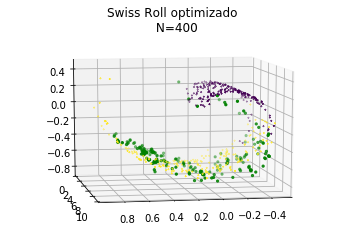

In [34]:
X_transported=res['x']
X_transported=X_transported.reshape(X_transported.shape[0]//dimension,dimension)

dat=X_transported

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 80)
ax.scatter(xs=dat[:,0], ys=dat[:,1], zs=dat[:,2], c='g', s=5)
ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2],marker='x',c=labels, s=1)
plt.title('Swiss Roll optimizado \n N=%s'%(data.shape[0]))

plt.show()

In [35]:

print(np.max(dat-Ycol))

1.7142786395153484


### Hacemos mas iteraciones, para que ¿mejore? mas (falla un poco, el gradiente me pega todos los puntos!!)

In [36]:
xinit=dat.flatten()

In [103]:
%%time
Nfeval=1
def callbackF(Xi):
    global Nfeval
    print ('Iteracion:'+ str(Nfeval)+',    f: '+str(costo_sin_x(Xi)[0]) )
    Nfeval += 1


opt={"disp": True, "maxiter":1000}

res = minimize(costo_sin_x, x0=xinit, jac=True,constraints=cons,options=opt, callback=callbackF)


Iteracion:1,    f: 8.142372826697867
Iteracion:2,    f: 8.139477326910487
Iteracion:3,    f: 8.141135984899504
Iteracion:4,    f: 8.141178374872457
Iteracion:5,    f: 8.141699565985899
Iteracion:6,    f: 8.141499730389882
Iteracion:7,    f: 8.141648914976335
Iteracion:8,    f: 8.141470426503066
Iteracion:9,    f: 8.14152766312204
Iteracion:10,    f: 8.141396292937364
Iteracion:11,    f: 8.141419904764915
Iteracion:12,    f: 732580.5376607116
Iteracion:13,    f: 8.149974304684374
Iteracion:14,    f: 195778.97599065604
Iteracion:15,    f: 115353.86985850826
Iteracion:16,    f: 2.0350126843790988e+16
Iteracion:17,    f: 8.150889040298637
Iteracion:18,    f: 8.149142852497166
Iteracion:19,    f: 8.146538855209824
Iteracion:20,    f: 8.144050197763097
Iteracion:21,    f: 8.142726584299623
Iteracion:22,    f: 8.141892814164514
Iteracion:23,    f: 9457490.214642914
Iteracion:24,    f: 8.15095011009755
Iteracion:25,    f: 8.149058775254483
Iteracion:26,    f: 8.143280306560374
Iteracion:27,   

Iteracion:215,    f: 8.126302917866967
Iteracion:216,    f: 8.126307277807529
Iteracion:217,    f: 8.126199693424105
Iteracion:218,    f: 8.126202556155839
Iteracion:219,    f: 8.126106372882102
Iteracion:220,    f: 8.126106837803269
Iteracion:221,    f: 8.126019719103867
Iteracion:222,    f: 8.126017767169962
Iteracion:223,    f: 8.125938178267399
Iteracion:224,    f: 8.125934052621083
Iteracion:225,    f: 8.125858192835953
Iteracion:226,    f: 8.125849173849074
Iteracion:227,    f: 8.125778663136922
Iteracion:228,    f: 8.125768079010852
Iteracion:229,    f: 8.125702253933813
Iteracion:230,    f: 8.125690279160715
Iteracion:231,    f: 8.125629102056106
Iteracion:232,    f: 8.125615977738377
Iteracion:233,    f: 8.125559083612757
Iteracion:234,    f: 8.122248036593856
Iteracion:235,    f: 8.125534887367317
Iteracion:236,    f: 8.125441561653869
Iteracion:237,    f: 8.125403467230047
Iteracion:238,    f: 8.12538416237308
Iteracion:239,    f: 8.125347012677079
Iteracion:240,    f: 8.125

Iteracion:426,    f: 8.06214222715109
Iteracion:427,    f: 8.062173052811758
Iteracion:428,    f: 8.062201164242492
Iteracion:429,    f: 8.062226292698767
Iteracion:430,    f: 8.062248542785268
Iteracion:431,    f: 8.062268254604325
Iteracion:432,    f: 8.062285813426886
Iteracion:433,    f: 8.062301595858807
Iteracion:434,    f: 8.06231593649835
Iteracion:435,    f: 8.062329084876842
Iteracion:436,    f: 8.062341299809011
Iteracion:437,    f: 8.062352787086944
Iteracion:438,    f: 8.06236307266273
Iteracion:439,    f: 8.062371180796575
Iteracion:440,    f: 8.062378670675031
Iteracion:441,    f: 8.062385914177623
Iteracion:442,    f: 8.062392964727104
Iteracion:443,    f: 8.062399862857179
Iteracion:444,    f: 8.062406638892744
Iteracion:445,    f: 8.06241331454569
Iteracion:446,    f: 8.062419905709438
Iteracion:447,    f: 8.062426423700236
Iteracion:448,    f: 8.062432876165333
Iteracion:449,    f: 8.062439267959128
Iteracion:450,    f: 3725443.5350343427
Iteracion:451,    f: 8.06246

Iteracion:637,    f: 8.058422970311518
Iteracion:638,    f: 8.05839897330054
Iteracion:639,    f: 8.058374382626326
Iteracion:640,    f: 8.26380684589053
Iteracion:641,    f: 8.058284157469755
Iteracion:642,    f: 8.058342296194697
Iteracion:643,    f: 8.058299552767982
Iteracion:644,    f: 8.058279343317713
Iteracion:645,    f: 8.058254940298745
Iteracion:646,    f: 8.058233632182937
Iteracion:647,    f: 8.058212840521355
Iteracion:648,    f: 8.05819290850501
Iteracion:649,    f: 8.058173465870908
Iteracion:650,    f: 8.058154431131825
Iteracion:651,    f: 8.058135693953236
Iteracion:652,    f: 8.05811718999292
Iteracion:653,    f: 8.058098868856295
Iteracion:654,    f: 8.05808069626906
Iteracion:655,    f: 8.058062648336671
Iteracion:656,    f: 8.05804470937915
Iteracion:657,    f: 8.058026869607854
Iteracion:658,    f: 8.058008343537374
Iteracion:659,    f: 8.057989254193146
Iteracion:660,    f: 8.057970276344774
Iteracion:661,    f: 8.057951409513501
Iteracion:662,    f: 8.05793265

Iteracion:849,    f: 8.048791799904029
Iteracion:850,    f: 8.048746274010032
Iteracion:851,    f: 8.048703142442056
Iteracion:852,    f: 8.048662194915925
Iteracion:853,    f: 8.048623237301815
Iteracion:854,    f: 8.048586092213888
Iteracion:855,    f: 8.048550597379606
Iteracion:856,    f: 8.04851660501414
Iteracion:857,    f: 8.048483980542194
Iteracion:858,    f: 8.048452601608517
Iteracion:859,    f: 8.048422357035756
Iteracion:860,    f: 8.048393145919423
Iteracion:861,    f: 8.04836487678309
Iteracion:862,    f: 8.048337466787457
Iteracion:863,    f: 8.048310840990782
Iteracion:864,    f: 8.048284931659254
Iteracion:865,    f: 8.048259677626167
Iteracion:866,    f: 8.048235023698467
Iteracion:867,    f: 8.04821092010341
Iteracion:868,    f: 8.048187321993266
Iteracion:869,    f: 8.048164189004396
Iteracion:870,    f: 8.048141485205706
Iteracion:871,    f: 8.048119177882834
Iteracion:872,    f: 8.048097237586061
Iteracion:873,    f: 8.048075637835192
Iteracion:874,    f: 8.04805

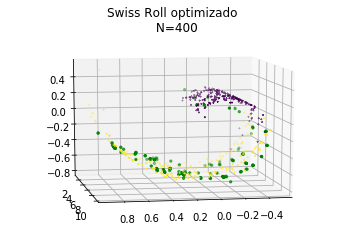

In [104]:
X_transported=res['x']
X_transported=X_transported.reshape(X_transported.shape[0]//dimension,dimension)

dat=X_transported

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 80)
ax.scatter(xs=dat[:,0], ys=dat[:,1], zs=dat[:,2], c='g', s=5)
ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2],marker='x',c=labels, s=1)
plt.title('Swiss Roll optimizado \n N=%s'%(data.shape[0]))

plt.show()

In [117]:
xinit=dat.flatten()

In [118]:
%%time
Nfeval=1
def callbackF(Xi):
    global Nfeval
    print ('Iteracion:'+ str(Nfeval)+',    f: '+str(costo_sin_x(Xi)[0]) )
    Nfeval += 1


opt={"disp": True, "maxiter":5000}

res = minimize(costo_sin_x, x0=xinit, jac=True,constraints=cons,options=opt, callback=callbackF)


Iteracion:1,    f: 8.02847283424719
Iteracion:2,    f: 8.028312181482331
Iteracion:3,    f: 8.028289705350428
Iteracion:4,    f: 8.02828027594128
Iteracion:5,    f: 8.028278217314051
Iteracion:6,    f: 8.028278226821584
Iteracion:7,    f: 8.028279258382602
Iteracion:8,    f: 8.028280289283106
Iteracion:9,    f: 8.02828111500926
Iteracion:10,    f: 8.028281644011194
Iteracion:11,    f: 8.028281901954632
Iteracion:12,    f: 8.028281935124404
Iteracion:13,    f: 8.028281795707876
Iteracion:14,    f: 8.0282815285259
Iteracion:15,    f: 8.028281169382605
Iteracion:16,    f: 8.028280745260803
Iteracion:17,    f: 8.028280275920668
Iteracion:18,    f: 8.028279775527714
Iteracion:19,    f: 8.028279254104875
Iteracion:20,    f: 8.028278718677813
Iteracion:21,    f: 8.028278174140752
Iteracion:22,    f: 8.028277623887966
Iteracion:23,    f: 8.028277070266329
Iteracion:24,    f: 8.02827651489521
Iteracion:25,    f: 8.028275958889548
Iteracion:26,    f: 8.028275403016302
Iteracion:27,    f: 8.02827

Iteracion:215,    f: 8.028219849423884
Iteracion:216,    f: 8.02821966883227
Iteracion:217,    f: 8.028219488398973
Iteracion:218,    f: 8.028219308123468
Iteracion:219,    f: 8.028219128005825
Iteracion:220,    f: 8.02821894804575
Iteracion:221,    f: 8.028218768242843
Iteracion:222,    f: 8.028218588597241
Iteracion:223,    f: 8.028218409108334
Iteracion:224,    f: 8.028218229776211
Iteracion:225,    f: 8.028218050600595
Iteracion:226,    f: 8.02821787158121
Iteracion:227,    f: 8.028217692717867
Iteracion:228,    f: 8.02821751401051
Iteracion:229,    f: 8.028217335458644
Iteracion:230,    f: 8.028217157062217
Iteracion:231,    f: 8.028216978821206
Iteracion:232,    f: 8.02821680073499
Iteracion:233,    f: 8.028216622803612
Iteracion:234,    f: 8.02821644502688
Iteracion:235,    f: 8.028216267404618
Iteracion:236,    f: 8.02821608993654
Iteracion:237,    f: 8.02821591262243
Iteracion:238,    f: 8.028215735462156
Iteracion:239,    f: 8.028215558455463
Iteracion:240,    f: 8.0282153816

Iteracion:427,    f: 8.028184799077211
Iteracion:428,    f: 8.028184647826313
Iteracion:429,    f: 8.028184496696277
Iteracion:430,    f: 8.028184345686865
Iteracion:431,    f: 8.02818419479808
Iteracion:432,    f: 8.028184044029445
Iteracion:433,    f: 8.028183893381312
Iteracion:434,    f: 8.02818374285306
Iteracion:435,    f: 8.02818359244483
Iteracion:436,    f: 8.02818344215636
Iteracion:437,    f: 8.028183291987478
Iteracion:438,    f: 8.02818314193814
Iteracion:439,    f: 8.028182992008203
Iteracion:440,    f: 8.028182842197518
Iteracion:441,    f: 8.02818269250571
Iteracion:442,    f: 8.02818254293317
Iteracion:443,    f: 8.028182393479133
Iteracion:444,    f: 8.028182244143867
Iteracion:445,    f: 8.028182094927097
Iteracion:446,    f: 8.028181945828631
Iteracion:447,    f: 8.028181796848363
Iteracion:448,    f: 8.02818164798636
Iteracion:449,    f: 8.028181499242226
Iteracion:450,    f: 8.028181350615903
Iteracion:451,    f: 8.02818120210723
Iteracion:452,    f: 8.02818105371

Iteracion:639,    f: 8.028155226417168
Iteracion:640,    f: 8.028155097867085
Iteracion:641,    f: 8.028154969411892
Iteracion:642,    f: 8.02815484105096
Iteracion:643,    f: 8.028154712784769
Iteracion:644,    f: 8.028154584612718
Iteracion:645,    f: 8.028154456535253
Iteracion:646,    f: 8.028154328551874
Iteracion:647,    f: 8.028154200662584
Iteracion:648,    f: 8.028154072867173
Iteracion:649,    f: 8.028153945165776
Iteracion:650,    f: 8.028153817557994
Iteracion:651,    f: 8.028153690044187
Iteracion:652,    f: 8.028153562623705
Iteracion:653,    f: 8.028153435296716
Iteracion:654,    f: 8.028153308063184
Iteracion:655,    f: 8.028153180922883
Iteracion:656,    f: 8.028153053875627
Iteracion:657,    f: 8.028152926921612
Iteracion:658,    f: 8.028152800060502
Iteracion:659,    f: 8.028152673292292
Iteracion:660,    f: 8.02815254661694
Iteracion:661,    f: 8.028152420033896
Iteracion:662,    f: 8.028152293543684
Iteracion:663,    f: 8.028152167145766
Iteracion:664,    f: 8.0281

Iteracion:851,    f: 8.028129911623296
Iteracion:852,    f: 8.028129800709989
Iteracion:853,    f: 8.02812968987113
Iteracion:854,    f: 8.028129579106015
Iteracion:855,    f: 8.02812946841495
Iteracion:856,    f: 8.028129357797955
Iteracion:857,    f: 8.02812924725473
Iteracion:858,    f: 8.02812913678517
Iteracion:859,    f: 8.028129026389488
Iteracion:860,    f: 8.028128916067255
Iteracion:861,    f: 8.028128805818705
Iteracion:862,    f: 8.028128695643579
Iteracion:863,    f: 8.028128585541861
Iteracion:864,    f: 8.028128475513638
Iteracion:865,    f: 8.028128365558661
Iteracion:866,    f: 8.028128255676762
Iteracion:867,    f: 8.028128145868102
Iteracion:868,    f: 8.028128036132479
Iteracion:869,    f: 8.028127926469962
Iteracion:870,    f: 8.02812781688011
Iteracion:871,    f: 8.028127707363298
Iteracion:872,    f: 8.028127597919147
Iteracion:873,    f: 8.028127488547769
Iteracion:874,    f: 8.02812737924911
Iteracion:875,    f: 8.028127270022788
Iteracion:876,    f: 8.02812716

Iteracion:1061,    f: 8.028108144759459
Iteracion:1062,    f: 8.028108047976476
Iteracion:1063,    f: 8.028107951254528
Iteracion:1064,    f: 8.028107854593355
Iteracion:1065,    f: 8.028107757993189
Iteracion:1066,    f: 8.028107661453864
Iteracion:1067,    f: 8.028107564975066
Iteracion:1068,    f: 8.028107468557256
Iteracion:1069,    f: 8.028107372199905
Iteracion:1070,    f: 8.028107275903425
Iteracion:1071,    f: 8.028107179667048
Iteracion:1072,    f: 8.028107083491577
Iteracion:1073,    f: 8.028106987376239
Iteracion:1074,    f: 8.028106891321476
Iteracion:1075,    f: 8.028106795326853
Iteracion:1076,    f: 8.028106699392454
Iteracion:1077,    f: 8.028106603518426
Iteracion:1078,    f: 8.0281065077046
Iteracion:1079,    f: 8.028106411950821
Iteracion:1080,    f: 8.028106316257075
Iteracion:1081,    f: 8.028106220623174
Iteracion:1082,    f: 8.028106125049618
Iteracion:1083,    f: 8.028106029535532
Iteracion:1084,    f: 8.028105934081843
Iteracion:1085,    f: 8.028105838687457
It

Iteracion:1268,    f: 8.028089335857276
Iteracion:1269,    f: 8.028089250622449
Iteracion:1270,    f: 8.028089165438736
Iteracion:1271,    f: 8.028089080305618
Iteracion:1272,    f: 8.028088995223662
Iteracion:1273,    f: 8.028088910192412
Iteracion:1274,    f: 8.028088825211993
Iteracion:1275,    f: 8.02808874028239
Iteracion:1276,    f: 8.028088655403394
Iteracion:1277,    f: 8.028088570575207
Iteracion:1278,    f: 8.028088485797571
Iteracion:1279,    f: 8.028088401070354
Iteracion:1280,    f: 8.028088316393884
Iteracion:1281,    f: 8.028088231767837
Iteracion:1282,    f: 8.028088147192186
Iteracion:1283,    f: 8.028088062667205
Iteracion:1284,    f: 8.0280879781925
Iteracion:1285,    f: 8.028087893768037
Iteracion:1286,    f: 8.028087809393645
Iteracion:1287,    f: 8.028087725069982
Iteracion:1288,    f: 8.028087640796032
Iteracion:1289,    f: 8.028087556572729
Iteracion:1290,    f: 8.028087472399106
Iteracion:1291,    f: 8.028087388275711
Iteracion:1292,    f: 8.028087304202481
Ite

Iteracion:1474,    f: 8.028072795754095
Iteracion:1475,    f: 8.028072720183046
Iteracion:1476,    f: 8.028072644655138
Iteracion:1477,    f: 8.028072569170405
Iteracion:1478,    f: 8.02807249372866
Iteracion:1479,    f: 8.028072418329902
Iteracion:1480,    f: 8.028072342974237
Iteracion:1481,    f: 8.028072267661335
Iteracion:1482,    f: 8.028072192391372
Iteracion:1483,    f: 8.02807211716454
Iteracion:1484,    f: 8.028072041980284
Iteracion:1485,    f: 8.028071966838748
Iteracion:1486,    f: 8.02807189174039
Iteracion:1487,    f: 8.028071816684474
Iteracion:1488,    f: 8.028071741671324
Iteracion:1489,    f: 8.028071666700956
Iteracion:1490,    f: 8.02807159177326
Iteracion:1491,    f: 8.028071516887909
Iteracion:1492,    f: 8.02807144204534
Iteracion:1493,    f: 8.028071367245293
Iteracion:1494,    f: 8.028071292487814
Iteracion:1495,    f: 8.028071217772743
Iteracion:1496,    f: 8.02807114310013
Iteracion:1497,    f: 8.02807106846993
Iteracion:1498,    f: 8.028070993882116
Iteraci

Iteracion:1680,    f: 8.028058092431376
Iteracion:1681,    f: 8.028058025075799
Iteracion:1682,    f: 8.028057957757376
Iteracion:1683,    f: 8.028057890475672
Iteracion:1684,    f: 8.028057823230888
Iteracion:1685,    f: 8.028057756022578
Iteracion:1686,    f: 8.028057688851387
Iteracion:1687,    f: 8.028057621716767
Iteracion:1688,    f: 8.028057554618593
Iteracion:1689,    f: 8.028057487557534
Iteracion:1690,    f: 8.028057420532642
Iteracion:1691,    f: 8.028057353544297
Iteracion:1692,    f: 8.028057286592722
Iteracion:1693,    f: 8.028057219677821
Iteracion:1694,    f: 8.028057152799436
Iteracion:1695,    f: 8.028057085957178
Iteracion:1696,    f: 8.028057019151648
Iteracion:1697,    f: 8.028056952382629
Iteracion:1698,    f: 8.02805688564985
Iteracion:1699,    f: 8.028056818953399
Iteracion:1700,    f: 8.028056752293569
Iteracion:1701,    f: 8.02805668566989
Iteracion:1702,    f: 8.028056619082363
Iteracion:1703,    f: 8.028056552531035
Iteracion:1704,    f: 8.028056486016427
It

Iteracion:1886,    f: 8.028044957763761
Iteracion:1887,    f: 8.028044897457464
Iteracion:1888,    f: 8.028044837183073
Iteracion:1889,    f: 8.028044776940034
Iteracion:1890,    f: 8.028044716728543
Iteracion:1891,    f: 8.028044656549207
Iteracion:1892,    f: 8.028044596401207
Iteracion:1893,    f: 8.028044536285174
Iteracion:1894,    f: 8.028044476200446
Iteracion:1895,    f: 8.028044416147424
Iteracion:1896,    f: 8.028044356126076
Iteracion:1897,    f: 8.02804429613597
Iteracion:1898,    f: 8.028044236177495
Iteracion:1899,    f: 8.02804417625051
Iteracion:1900,    f: 8.028044116354998
Iteracion:1901,    f: 8.028044056491169
Iteracion:1902,    f: 8.028043996658512
Iteracion:1903,    f: 8.028043936857541
Iteracion:1904,    f: 8.028043877087532
Iteracion:1905,    f: 8.028043817349257
Iteracion:1906,    f: 8.028043757642234
Iteracion:1907,    f: 8.02804369796635
Iteracion:1908,    f: 8.028043638322037
Iteracion:1909,    f: 8.0280435787088
Iteracion:1910,    f: 8.028043519127188
Itera

Iteracion:2092,    f: 8.028033174345977
Iteracion:2093,    f: 8.02803312013626
Iteracion:2094,    f: 8.028033065954332
Iteracion:2095,    f: 8.02803301179931
Iteracion:2096,    f: 8.028032957672616
Iteracion:2097,    f: 8.028032903572946
Iteracion:2098,    f: 8.02803284950052
Iteracion:2099,    f: 8.028032795455866
Iteracion:2100,    f: 8.028032741438881
Iteracion:2101,    f: 8.028032687448746
Iteracion:2102,    f: 8.028032633486426
Iteracion:2103,    f: 8.02803257955123
Iteracion:2104,    f: 8.028032525643884
Iteracion:2105,    f: 8.028032471763584
Iteracion:2106,    f: 8.028032417910628
Iteracion:2107,    f: 8.028032364084934
Iteracion:2108,    f: 8.028032310286632
Iteracion:2109,    f: 8.02803225651572
Iteracion:2110,    f: 8.028032202771934
Iteracion:2111,    f: 8.02803214905558
Iteracion:2112,    f: 8.028032095366111
Iteracion:2113,    f: 8.028032041704051
Iteracion:2114,    f: 8.028031988069156
Iteracion:2115,    f: 8.028031934461485
Iteracion:2116,    f: 8.028031880881121
Iterac

Iteracion:2299,    f: 8.028022514824608
Iteracion:2300,    f: 8.028022465948954
Iteracion:2301,    f: 8.028022417097816
Iteracion:2302,    f: 8.028022368270612
Iteracion:2303,    f: 8.02802231946737
Iteracion:2304,    f: 8.028022270688131
Iteracion:2305,    f: 8.028022221933032
Iteracion:2306,    f: 8.028022173201578
Iteracion:2307,    f: 8.02802212449421
Iteracion:2308,    f: 8.028022075811199
Iteracion:2309,    f: 8.028022027151762
Iteracion:2310,    f: 8.028021978516426
Iteracion:2311,    f: 8.028021929904792
Iteracion:2312,    f: 8.028021881317306
Iteracion:2313,    f: 8.028021832753701
Iteracion:2314,    f: 8.02802178421401
Iteracion:2315,    f: 8.028021735697688
Iteracion:2316,    f: 8.028021687205694
Iteracion:2317,    f: 8.028021638737556
Iteracion:2318,    f: 8.028021590292724
Iteracion:2319,    f: 8.028021541872267
Iteracion:2320,    f: 8.028021493475466
Iteracion:2321,    f: 8.028021445102363
Iteracion:2322,    f: 8.028021396752752
Iteracion:2323,    f: 8.028021348427053
Ite

Iteracion:2505,    f: 8.028012933542012
Iteracion:2506,    f: 8.028012889317454
Iteracion:2507,    f: 8.028012845114732
Iteracion:2508,    f: 8.028012800932792
Iteracion:2509,    f: 8.028012756771801
Iteracion:2510,    f: 8.028012712632556
Iteracion:2511,    f: 8.028012668514078
Iteracion:2512,    f: 8.028012624416716
Iteracion:2513,    f: 8.028012580340274
Iteracion:2514,    f: 8.028012536285056
Iteracion:2515,    f: 8.028012492250863
Iteracion:2516,    f: 8.028012448237707
Iteracion:2517,    f: 8.0280124042456
Iteracion:2518,    f: 8.028012360274186
Iteracion:2519,    f: 8.02801231632447
Iteracion:2520,    f: 8.028012272395285
Iteracion:2521,    f: 8.02801222848674
Iteracion:2522,    f: 8.028012184600053
Iteracion:2523,    f: 8.028012140733916
Iteracion:2524,    f: 8.028012096888379
Iteracion:2525,    f: 8.02801205306381
Iteracion:2526,    f: 8.028012009260632
Iteracion:2527,    f: 8.028011965477951
Iteracion:2528,    f: 8.028011921716349
Iteracion:2529,    f: 8.028011877975487
Itera

Iteracion:2711,    f: 8.028004252222978
Iteracion:2712,    f: 8.028004212098216
Iteracion:2713,    f: 8.028004171991322
Iteracion:2714,    f: 8.028004131903735
Iteracion:2715,    f: 8.028004091834477
Iteracion:2716,    f: 8.028004051783869
Iteracion:2717,    f: 8.028004011752119
Iteracion:2718,    f: 8.028003971738862
Iteracion:2719,    f: 8.028003931744108
Iteracion:2720,    f: 8.028003891768444
Iteracion:2721,    f: 8.02800385181116
Iteracion:2722,    f: 8.028003811872006
Iteracion:2723,    f: 8.028003771951964
Iteracion:2724,    f: 8.028003732050228
Iteracion:2725,    f: 8.028003692167474
Iteracion:2726,    f: 8.028003652302667
Iteracion:2727,    f: 8.028003612456882
Iteracion:2728,    f: 8.028003572629348
Iteracion:2729,    f: 8.028003532820412
Iteracion:2730,    f: 8.028003493030264
Iteracion:2731,    f: 8.028003453258119
Iteracion:2732,    f: 8.02800341350459
Iteracion:2733,    f: 8.028003373769991
Iteracion:2734,    f: 8.028003334053029
Iteracion:2735,    f: 8.02800329435528
Ite

Iteracion:2917,    f: 8.027996365893019
Iteracion:2918,    f: 8.027996329397613
Iteracion:2919,    f: 8.027996292918205
Iteracion:2920,    f: 8.027996256456012
Iteracion:2921,    f: 8.027996220009896
Iteracion:2922,    f: 8.027996183580255
Iteracion:2923,    f: 8.027996147167423
Iteracion:2924,    f: 8.02799611077137
Iteracion:2925,    f: 8.027996074391483
Iteracion:2926,    f: 8.027996038028256
Iteracion:2927,    f: 8.027996001681483
Iteracion:2928,    f: 8.027995965351115
Iteracion:2929,    f: 8.027995929037505
Iteracion:2930,    f: 8.027995892740524
Iteracion:2931,    f: 8.027995856459677
Iteracion:2932,    f: 8.027995820195422
Iteracion:2933,    f: 8.02799578394764
Iteracion:2934,    f: 8.027995747715764
Iteracion:2935,    f: 8.027995711501031
Iteracion:2936,    f: 8.02799567530232
Iteracion:2937,    f: 8.027995639120228
Iteracion:2938,    f: 8.02799560295459
Iteracion:2939,    f: 8.027995566805467
Iteracion:2940,    f: 8.027995530672376
Iteracion:2941,    f: 8.027995494556203
Iter

Iteracion:3123,    f: 8.027989184975782
Iteracion:3124,    f: 8.027989151706974
Iteracion:3125,    f: 8.027989118453739
Iteracion:3126,    f: 8.027989085214543
Iteracion:3127,    f: 8.027989051990568
Iteracion:3128,    f: 8.027989018781016
Iteracion:3129,    f: 8.027988985586669
Iteracion:3130,    f: 8.027988952407002
Iteracion:3131,    f: 8.027988919241887
Iteracion:3132,    f: 8.027988886091473
Iteracion:3133,    f: 8.027988852955938
Iteracion:3134,    f: 8.027988819834565
Iteracion:3135,    f: 8.027988786728216
Iteracion:3136,    f: 8.027988753636901
Iteracion:3137,    f: 8.02798872055991
Iteracion:3138,    f: 8.027988687497526
Iteracion:3139,    f: 8.027988654450132
Iteracion:3140,    f: 8.02798862141717
Iteracion:3141,    f: 8.027988588398888
Iteracion:3142,    f: 8.027988555395421
Iteracion:3143,    f: 8.027988522406597
Iteracion:3144,    f: 8.027988489432135
Iteracion:3145,    f: 8.027988456472254
Iteracion:3146,    f: 8.027988423527436
Iteracion:3147,    f: 8.027988390597072
It

Iteracion:3329,    f: 8.027982632438121
Iteracion:3330,    f: 8.027982602049484
Iteracion:3331,    f: 8.027982571674222
Iteracion:3332,    f: 8.027982541312557
Iteracion:3333,    f: 8.027982510963803
Iteracion:3334,    f: 8.027982480628559
Iteracion:3335,    f: 8.027982450306009
Iteracion:3336,    f: 8.027982419996693
Iteracion:3337,    f: 8.027982389700748
Iteracion:3338,    f: 8.027982359418203
Iteracion:3339,    f: 8.027982329148214
Iteracion:3340,    f: 8.027982298891574
Iteracion:3341,    f: 8.027982268648435
Iteracion:3342,    f: 8.027982238418057
Iteracion:3343,    f: 8.027982208201193
Iteracion:3344,    f: 8.02798217799719
Iteracion:3345,    f: 8.027982147806421
Iteracion:3346,    f: 8.027982117628614
Iteracion:3347,    f: 8.027982087464409
Iteracion:3348,    f: 8.02798205731218
Iteracion:3349,    f: 8.027982027174062
Iteracion:3350,    f: 8.02798199704838
Iteracion:3351,    f: 8.027981966936347
Iteracion:3352,    f: 8.027981936836486
Iteracion:3353,    f: 8.02798190675064
Iter

Iteracion:3535,    f: 8.027976641555766
Iteracion:3536,    f: 8.027976613745745
Iteracion:3537,    f: 8.02797658594743
Iteracion:3538,    f: 8.027976558161155
Iteracion:3539,    f: 8.027976530386724
Iteracion:3540,    f: 8.027976502624075
Iteracion:3541,    f: 8.0279764748732
Iteracion:3542,    f: 8.027976447134172
Iteracion:3543,    f: 8.027976419406743
Iteracion:3544,    f: 8.027976391691686
Iteracion:3545,    f: 8.027976363988268
Iteracion:3546,    f: 8.027976336296433
Iteracion:3547,    f: 8.027976308615823
Iteracion:3548,    f: 8.027976280947842
Iteracion:3549,    f: 8.027976253290861
Iteracion:3550,    f: 8.027976225646242
Iteracion:3551,    f: 8.027976198013523
Iteracion:3552,    f: 8.027976170392387
Iteracion:3553,    f: 8.027976142782181
Iteracion:3554,    f: 8.027976115184915
Iteracion:3555,    f: 8.027976087598677
Iteracion:3556,    f: 8.027976060024425
Iteracion:3557,    f: 8.027976032462288
Iteracion:3558,    f: 8.027976004911418
Iteracion:3559,    f: 8.027975977371636
Ite

Iteracion:3741,    f: 8.027971154147602
Iteracion:3742,    f: 8.027971128652162
Iteracion:3743,    f: 8.027971103167168
Iteracion:3744,    f: 8.027971077692296
Iteracion:3745,    f: 8.027971052228734
Iteracion:3746,    f: 8.027971026775791
Iteracion:3747,    f: 8.027971001332745
Iteracion:3748,    f: 8.027970975900942
Iteracion:3749,    f: 8.027970950479853
Iteracion:3750,    f: 8.0279709250686
Iteracion:3751,    f: 8.027970899669132
Iteracion:3752,    f: 8.027970874279072
Iteracion:3753,    f: 8.027970848900573
Iteracion:3754,    f: 8.027970823531767
Iteracion:3755,    f: 8.02797079817396
Iteracion:3756,    f: 8.027970772826725
Iteracion:3757,    f: 8.027970747490176
Iteracion:3758,    f: 8.027970722163989
Iteracion:3759,    f: 8.027970696848298
Iteracion:3760,    f: 8.027970671543901
Iteracion:3761,    f: 8.027970646249084
Iteracion:3762,    f: 8.027970620965581
Iteracion:3763,    f: 8.02797059569218
Iteracion:3764,    f: 8.027970570428785
Iteracion:3765,    f: 8.027970545176794
Iter

Iteracion:3948,    f: 8.02796609575155
Iteracion:3949,    f: 8.027966072347539
Iteracion:3950,    f: 8.027966048952615
Iteracion:3951,    f: 8.027966025567522
Iteracion:3952,    f: 8.02796600219189
Iteracion:3953,    f: 8.02796597882595
Iteracion:3954,    f: 8.027965955470158
Iteracion:3955,    f: 8.027965932122893
Iteracion:3956,    f: 8.027965908785859
Iteracion:3957,    f: 8.027965885457819
Iteracion:3958,    f: 8.027965862140096
Iteracion:3959,    f: 8.027965838831342
Iteracion:3960,    f: 8.027965815532315
Iteracion:3961,    f: 8.02796579224265
Iteracion:3962,    f: 8.027965768962702
Iteracion:3963,    f: 8.02796574569138
Iteracion:3964,    f: 8.027965722431029
Iteracion:3965,    f: 8.027965699178917
Iteracion:3966,    f: 8.027965675936654
Iteracion:3967,    f: 8.027965652704612
Iteracion:3968,    f: 8.027965629481205
Iteracion:3969,    f: 8.027965606268333
Iteracion:3970,    f: 8.02796558306379
Iteracion:3971,    f: 8.027965559869175
Iteracion:3972,    f: 8.0279655366843
Iteracio

Iteracion:4154,    f: 8.027961470022545
Iteracion:4155,    f: 8.027961448493757
Iteracion:4156,    f: 8.02796142697345
Iteracion:4157,    f: 8.027961405461994
Iteracion:4158,    f: 8.027961383958795
Iteracion:4159,    f: 8.027961362464492
Iteracion:4160,    f: 8.027961340978834
Iteracion:4161,    f: 8.027961319501767
Iteracion:4162,    f: 8.027961298032837
Iteracion:4163,    f: 8.027961276573444
Iteracion:4164,    f: 8.027961255122124
Iteracion:4165,    f: 8.027961233679266
Iteracion:4166,    f: 8.027961212245259
Iteracion:4167,    f: 8.02796119081974
Iteracion:4168,    f: 8.02796116940239
Iteracion:4169,    f: 8.027961147993771
Iteracion:4170,    f: 8.027961126594311
Iteracion:4171,    f: 8.027961105202294
Iteracion:4172,    f: 8.027961083819525
Iteracion:4173,    f: 8.027961062444994
Iteracion:4174,    f: 8.027961041079443
Iteracion:4175,    f: 8.027961019721953
Iteracion:4176,    f: 8.02796099837313
Iteracion:4177,    f: 8.027960977032635
Iteracion:4178,    f: 8.027960955700705
Iter

Iteracion:4360,    f: 8.027957209984056
Iteracion:4361,    f: 8.02795719011119
Iteracion:4362,    f: 8.02795717024658
Iteracion:4363,    f: 8.027957150389144
Iteracion:4364,    f: 8.027957130538143
Iteracion:4365,    f: 8.027957110694944
Iteracion:4366,    f: 8.02795709085897
Iteracion:4367,    f: 8.027957071030249
Iteracion:4368,    f: 8.027957051209292
Iteracion:4369,    f: 8.027957031394767
Iteracion:4370,    f: 8.02795701158819
Iteracion:4371,    f: 8.027956991788411
Iteracion:4372,    f: 8.027956971995797
Iteracion:4373,    f: 8.02795695221098
Iteracion:4374,    f: 8.027956932432582
Iteracion:4375,    f: 8.027956912662743
Iteracion:4376,    f: 8.02795689289959
Iteracion:4377,    f: 8.027956873143363
Iteracion:4378,    f: 8.027956853394485
Iteracion:4379,    f: 8.027956833652794
Iteracion:4380,    f: 8.027956813918484
Iteracion:4381,    f: 8.027956794191498
Iteracion:4382,    f: 8.027956774471667
Iteracion:4383,    f: 8.027956754759044
Iteracion:4384,    f: 8.027956735053433
Iterac

Iteracion:4566,    f: 8.027953265788835
Iteracion:4567,    f: 8.027953247353311
Iteracion:4568,    f: 8.027953228924266
Iteracion:4569,    f: 8.027953210502323
Iteracion:4570,    f: 8.027953192086795
Iteracion:4571,    f: 8.02795317367809
Iteracion:4572,    f: 8.027953155275577
Iteracion:4573,    f: 8.027953136880402
Iteracion:4574,    f: 8.02795311849108
Iteracion:4575,    f: 8.027953100109015
Iteracion:4576,    f: 8.027953081732342
Iteracion:4577,    f: 8.027953063364311
Iteracion:4578,    f: 8.027953045001489
Iteracion:4579,    f: 8.027953026646168
Iteracion:4580,    f: 8.02795300829733
Iteracion:4581,    f: 8.027952989954397
Iteracion:4582,    f: 8.027952971618795
Iteracion:4583,    f: 8.027952953288896
Iteracion:4584,    f: 8.027952934966558
Iteracion:4585,    f: 8.027952916650714
Iteracion:4586,    f: 8.027952898340988
Iteracion:4587,    f: 8.027952880038573
Iteracion:4588,    f: 8.027952861742095
Iteracion:4589,    f: 8.027952843452676
Iteracion:4590,    f: 8.027952825169965
Ite

Iteracion:4772,    f: 8.027949604613964
Iteracion:4773,    f: 8.027949587490749
Iteracion:4774,    f: 8.027949570373167
Iteracion:4775,    f: 8.027949553262294
Iteracion:4776,    f: 8.027949536157221
Iteracion:4777,    f: 8.027949519058033
Iteracion:4778,    f: 8.027949501964683
Iteracion:4779,    f: 8.027949484878224
Iteracion:4780,    f: 8.027949467796756
Iteracion:4781,    f: 8.027949387945295
Iteracion:4782,    f: 8.027949148364067
Iteracion:4783,    f: 8.027948908857988
Iteracion:4784,    f: 8.027948669424292
Iteracion:4785,    f: 8.027948430063656
Iteracion:4786,    f: 8.027948190776685
Iteracion:4787,    f: 8.027947951561696
Iteracion:4788,    f: 8.027947712420449
Iteracion:4789,    f: 8.02794747335155
Iteracion:4790,    f: 8.027947234355556
Iteracion:4791,    f: 8.027946995432576
Iteracion:4792,    f: 8.027946756582393
Iteracion:4793,    f: 8.027946517804553
Iteracion:4794,    f: 8.02794627909996
Iteracion:4795,    f: 8.027946040467137
Iteracion:4796,    f: 8.027945801907743
It

Iteracion:4978,    f: 8.027903566279637
Iteracion:4979,    f: 8.027903340563514
Iteracion:4980,    f: 8.027903114915135
Iteracion:4981,    f: 8.027902889334959
Iteracion:4982,    f: 8.027902663821802
Iteracion:4983,    f: 8.027902438377321
Iteracion:4984,    f: 8.027902212999445
Iteracion:4985,    f: 8.027901987690115
Iteracion:4986,    f: 8.027901762448174
Iteracion:4987,    f: 8.027901537274165
Iteracion:4988,    f: 8.027901312167762
Iteracion:4989,    f: 8.027901087128035
Iteracion:4990,    f: 8.027900862155567
Iteracion:4991,    f: 8.027900637252285
Iteracion:4992,    f: 8.027900412415127
Iteracion:4993,    f: 8.02790018764657
Iteracion:4994,    f: 8.027899962944604
Iteracion:4995,    f: 8.02789973830989
Iteracion:4996,    f: 8.027899513743703
Iteracion:4997,    f: 8.027899289243594
Iteracion:4998,    f: 8.027899064811356
Iteracion:4999,    f: 8.027898840446658
Iteracion:5000,    f: 8.027898616148535
Iteracion:5001,    f: 8.028799209847179
Iteration limit exceeded    (Exit mode 9)


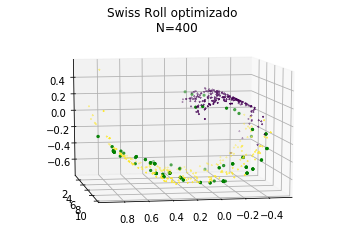

In [119]:
X_transported=res['x']
X_transported=X_transported.reshape(X_transported.shape[0]//dimension,dimension)

dat=X_transported

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 80)
ax.scatter(xs=dat[:,0], ys=dat[:,1], zs=dat[:,2], c='g', s=5)
ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2],marker='x',c=labels, s=1)
plt.title('Swiss Roll optimizado \n N=%s'%(data.shape[0]))

plt.show()

#### y si pruebo con un punto inicial malo? medio medio...

In [43]:
alphaESP=4
kESP=5#cuanos vecinos miro para decidir la distancia a la que esta el nuevo punto
        
dataESP=np.concatenate((Zcol,Ycol),axis=0)
distanciasESP=np.matrix(distance_matrix(dataESP,dataESP))

modelESP=F.Fermat(alphaESP, path_method='FW')
modelESP.fit(distanciasESP)
distESP=modelESP.get_distances()
treeESP = KDTree(dataESP, leaf_size=2)

def costo_sin_x(x):
    
    xposta=x.reshape(x.shape[0]//dimension,dimension)
     
    res=0
    gradient=np.ones(x.shape)
    for i in range(Zcol.shape[0]):
        aux,grad_idx=distanciaFermat(i,xposta[i,:],distESP,treeESP,kESP) 
        res+=aux
        
        q=dataESP[grad_idx,:] #el ultimo mas cercano en el "mejor camino"
        grad=alphaESP*(np.linalg.norm(q-xposta[i,:])**(alphaESP-2))*(xposta[i,:]-q) #EL gradiente
        
        gradient[3*i]=grad[0]
        gradient[3*i+1]=grad[1]
        gradient[3*i+2]=grad[2]
    return res,gradient



def distanciaFermat(idx,end,dist,tree,k):
    d,ind=tree.query([end],k=k)
    d=np.power(d,alphaESP)
    ret=min([ dist[idx,ind[0,i]]+d[0,i] for i in range(d.shape[1])])
    
    indice=np.argmin([ dist[idx,ind[0,i]] for i in range(ind.shape[1])]) 
    
    grad_idx=ind[0,indice] #DEVUELVE EL INDICE DEL VECINO que esta a menor dist_fer de idx
    
    return ret,grad_idx



def costo_sin_x_ni_grad(x):
    
    xposta=x.reshape(x.shape[0]//dimension,dimension)
     
    res=0
    for i in range(Zcol.shape[0]):
        aux,grad_idx=distanciaFermat(i,xposta[i,:],distESP,treeESP,kESP) 
        res+=aux
    return res

In [39]:
aux0=np.tile([1,0,0],puntos)
aux1=np.tile([0,1,0],puntos)
aux2=np.tile([0,0,1],puntos)
A=np.zeros((dimension,dimension*puntos))
A[0,:]=aux0
A[1,:]=aux1
A[2,:]=aux2
A=A/puntos
b=np.mean(Ycol,axis=0)

#RESTRICCIONES DE IGUALDAD
con2 = lambda x: np.dot(A[2,:],x)- b[2]
con1 = lambda x: np.dot(A[1,:], x) - b[1]
con0 = lambda x: np.dot(A[0,:], x ) - b[0]



A00 = np.kron(np.eye(puntos),np.array([[1,0,0],[0,0,0],[0,0,0]])) 
A01 = np.kron(np.eye(puntos),np.array([[0,0,0],[1,0,0],[0,0,0]])) 
A02 = np.kron(np.eye(puntos),np.array([[0,0,0],[0,0,0],[1,0,0]]))
A11 = np.kron(np.eye(puntos),np.array([[0,0,0],[0,1,0],[0,0,0]]))
A12 = np.kron(np.eye(puntos),np.array([[0,0,0],[0,0,0],[0,1,0]]))
A22 = np.kron(np.eye(puntos),np.array([[0,0,0],[0,0,0],[0,0,1]]))


def con00(x):
    return (x@A00@x.T - Y@A00@Y.T )/puntos 

def con01(x):
    return (x@A01@x.T - Y@A01@Y.T )/puntos                   
                   
def con02(x):
    return (x@A02@x.T - Y@A02@Y.T )/puntos
    
#jac02
def con11(x):
    return (x@A11@x.T - Y@A11@Y.T )/puntos
#jac11
def con12(x):
    return (x@A12@x.T - Y@A12@Y.T )/puntos
#jac12
def con22(x):
    return (x@A22@x.T - Y@A22@Y.T )/puntos
#jac22


cons = [{'type': 'eq', 'fun': con0,'jac': lambda x: A[0,:]},
        {'type': 'eq', 'fun': con1,'jac': lambda x: A[1,:]},
        {'type': 'eq', 'fun': con2,'jac': lambda x: A[2,:]},
        {'type': 'eq', 'fun': con00,'jac': lambda x: 2*A00@x.T/puntos},
        {'type': 'eq', 'fun': con01,'jac': lambda x: 2*A01@x.T/puntos},
        {'type': 'eq', 'fun': con02,'jac': lambda x: 2*A02@x.T/puntos},
        {'type': 'eq', 'fun': con11,'jac': lambda x: 2*A11@x.T/puntos},
        {'type': 'eq', 'fun': con12,'jac': lambda x: 2*A12@x.T/puntos},
        {'type': 'eq', 'fun': con22,'jac': lambda x: 2*A22@x.T/puntos}  ]


#LINEAR CONSTRAINTS
#eps=0.1*np.ones(b.shape)
#cons = LinearConstraint(A,b-eps,b+eps)
#cons=LinearConstraint(A,b,b)

#XINICIAL, QUE VA
xinit = Zcol.flatten()

#ACA PUEDO PONER OPCIONES
opt={"disp": True, "maxiter":2000}

In [40]:
%%time
Nfeval=1
def callbackF(Xi,d=None):
    global Nfeval
    print ('Iteracion:'+ str(Nfeval)+',    f: '+str(costo_sin_x(Xi)[0]) )
    Nfeval += 1



res = minimize(costo_sin_x, x0=xinit, jac=True,constraints=cons,options=opt, callback=callbackF)


Iteracion:1,    f: 156064.84796740228
Iteracion:2,    f: 8242.286251993091
Iteracion:3,    f: 934.9382110188654
Iteracion:4,    f: 2575.974441507107
Iteracion:5,    f: 1410.9849701373112
Iteracion:6,    f: 513.6426292062705
Iteracion:7,    f: 1066.4919437444748
Iteracion:8,    f: 3146.092971363082
Iteracion:9,    f: 8783.085403479208
Iteracion:10,    f: 506.94685223716925
Iteracion:11,    f: 376.2183272760377
Iteracion:12,    f: 698.1469414484138
Iteracion:13,    f: 63.34369247745619
Iteracion:14,    f: 4.690024512029574
Iteracion:15,    f: 4.565106127029587
Iteracion:16,    f: 2.7393531630723125
Iteracion:17,    f: 1.4260361134080959
Iteracion:18,    f: 0.7704866945822687
Iteracion:19,    f: 0.6017876592365975
Iteracion:20,    f: 0.5608415208673653
Iteracion:21,    f: 0.48683611214692696
Iteracion:22,    f: 0.4701782690897401
Iteracion:23,    f: 0.48154909434323917
Iteracion:24,    f: 0.5952129352339806
Iteracion:25,    f: 0.6312976521253991
Iteracion:26,    f: 0.4770051192485496
Iter

Iteracion:208,    f: 0.4378732770476867
Iteracion:209,    f: 0.43785951632616693
Iteracion:210,    f: 0.43784626144254873
Iteracion:211,    f: 0.4378334961365317
Iteracion:212,    f: 0.4378212047941706
Iteracion:213,    f: 0.43780937241585893
Iteracion:214,    f: 0.4377979845894065
Iteracion:215,    f: 0.4377870274608456
Iteracion:216,    f: 0.43777648770892824
Iteracion:217,    f: 0.43776635252010704
Iteracion:218,    f: 0.43775660956671564
Iteracion:219,    f: 0.43774724698284484
Iteracion:220,    f: 0.43773825334479705
Iteracion:221,    f: 0.43772961765179197
Iteracion:222,    f: 0.4377213293057787
Iteracion:223,    f: 39620973.76015988
Iteracion:224,    f: 2.0235495237503573
Iteracion:225,    f: 0.4453657467519214
Iteracion:226,    f: 0.44250139861010934
Iteracion:227,    f: 0.4415673961935374
Iteracion:228,    f: 0.44053380613715964
Iteracion:229,    f: 0.4399568305181937
Iteracion:230,    f: 0.43936960781892215
Iteracion:231,    f: 0.43915995531181323
Iteracion:232,    f: 0.43867

Iteracion:411,    f: 0.4464876850599313
Iteracion:412,    f: 0.4465119286718879
Iteracion:413,    f: 0.44653527470787746
Iteracion:414,    f: 0.4465581768840952
Iteracion:415,    f: 0.4465806226571371
Iteracion:416,    f: 0.44660261134889584
Iteracion:417,    f: 0.4466241397955469
Iteracion:418,    f: 0.44664163826215547
Iteracion:419,    f: 0.44665774433256705
Iteracion:420,    f: 0.4466736806385118
Iteracion:421,    f: 0.44668943594481136
Iteracion:422,    f: 0.4467050024281143
Iteracion:423,    f: 0.44672037360155176
Iteracion:424,    f: 0.4467355452552997
Iteracion:425,    f: 0.44675051433356366
Iteracion:426,    f: 0.4467652793304016
Iteracion:427,    f: 0.446778230051199
Iteracion:428,    f: 0.4467908452033767
Iteracion:429,    f: 0.4468033172001001
Iteracion:430,    f: 0.4468156461429359
Iteracion:431,    f: 0.4468278327438983
Iteracion:432,    f: 0.4468398782812669
Iteracion:433,    f: 0.4468517844680371
Iteracion:434,    f: 0.4468635534096894
Iteracion:435,    f: 0.44687518751

Iteracion:614,    f: 0.45281023435996465
Iteracion:615,    f: 0.45281164290449244
Iteracion:616,    f: 0.45281303768024384
Iteracion:617,    f: 0.4528144180431186
Iteracion:618,    f: 0.45281578340584694
Iteracion:619,    f: 0.4528171331297177
Iteracion:620,    f: 0.4528184666353832
Iteracion:621,    f: 0.4528197833268178
Iteracion:622,    f: 0.45282108263932364
Iteracion:623,    f: 0.45282236403782405
Iteracion:624,    f: 0.4528236270119376
Iteracion:625,    f: 0.4528248710680364
Iteracion:626,    f: 0.4528260957664662
Iteracion:627,    f: 0.45282730068004456
Iteracion:628,    f: 0.45282848543257764
Iteracion:629,    f: 0.4528296496675608
Iteracion:630,    f: 0.452830793069147
Iteracion:631,    f: 0.452831915355922
Iteracion:632,    f: 0.4528330162731955
Iteracion:633,    f: 0.4528340956076675
Iteracion:634,    f: 0.4528351531626531
Iteracion:635,    f: 0.4528361887890097
Iteracion:636,    f: 0.4528372023615419
Iteracion:637,    f: 0.4528381937725322
Iteracion:638,    f: 0.45283916295

Iteracion:817,    f: 0.4527900887247502
Iteracion:818,    f: 0.4527763585289486
Iteracion:819,    f: 0.4527629012935677
Iteracion:820,    f: 0.45274971846832157
Iteracion:821,    f: 0.45273681082959355
Iteracion:822,    f: 0.4527241785867968
Iteracion:823,    f: 0.4527118214000353
Iteracion:824,    f: 0.4526997384560634
Iteracion:825,    f: 0.452687928501101
Iteracion:826,    f: 0.4526763898884719
Iteracion:827,    f: 0.4526651206128237
Iteracion:828,    f: 0.45265411836374014
Iteracion:829,    f: 0.4526433805392205
Iteracion:830,    f: 0.4526329042884324
Iteracion:831,    f: 0.4526226865439695
Iteracion:832,    f: 0.4526127240350803
Iteracion:833,    f: 0.45260301332207037
Iteracion:834,    f: 0.45259355082831293
Iteracion:835,    f: 0.4525843328315802
Iteracion:836,    f: 0.4525753555209745
Iteracion:837,    f: 0.4525666149828195
Iteracion:838,    f: 0.45255810722639567
Iteracion:839,    f: 0.45254982820914147
Iteracion:840,    f: 0.4525417738439742
Iteracion:841,    f: 0.45253393999

Iteracion:1020,    f: 0.452396455201874
Iteracion:1021,    f: 0.4523938540733464
Iteracion:1022,    f: 0.45239127247943217
Iteracion:1023,    f: 0.45238871009120735
Iteracion:1024,    f: 0.4523861666119991
Iteracion:1025,    f: 0.45238364173767454
Iteracion:1026,    f: 0.4523811351864214
Iteracion:1027,    f: 0.45237864665481003
Iteracion:1028,    f: 0.4523761758806865
Iteracion:1029,    f: 0.45237372256959313
Iteracion:1030,    f: 0.4523712864742969
Iteracion:1031,    f: 0.45236886732490583
Iteracion:1032,    f: 0.45236646486228577
Iteracion:1033,    f: 0.45236407884331187
Iteracion:1034,    f: 0.4523617090143487
Iteracion:1035,    f: 0.4523593551463577
Iteracion:1036,    f: 0.45235701699866876
Iteracion:1037,    f: 0.4523546943460821
Iteracion:1038,    f: 0.4523523869596209
Iteracion:1039,    f: 0.4523500946302516
Iteracion:1040,    f: 0.45234781713643607
Iteracion:1041,    f: 0.4523455542746017
Iteracion:1042,    f: 0.45234330584127774
Iteracion:1043,    f: 0.45234107162577925
Itera

Iteracion:1219,    f: 0.4520756089003908
Iteracion:1220,    f: 0.4520746783346028
Iteracion:1221,    f: 0.452073753935902
Iteracion:1222,    f: 0.45207283569946594
Iteracion:1223,    f: 0.4520719236438059
Iteracion:1224,    f: 0.45207101776689795
Iteracion:1225,    f: 0.4520701180686825
Iteracion:1226,    f: 0.45206922456485527
Iteracion:1227,    f: 0.45206833725446177
Iteracion:1228,    f: 0.4520674561399738
Iteracion:1229,    f: 0.4520665812297536
Iteracion:1230,    f: 0.45206571252778377
Iteracion:1231,    f: 0.4520648500417298
Iteracion:1232,    f: 0.4520639937744681
Iteracion:1233,    f: 0.4520631437312397
Iteracion:1234,    f: 0.4520622999158576
Iteracion:1235,    f: 0.45206146234194833
Iteracion:1236,    f: 0.45206063099957156
Iteracion:1237,    f: 0.4520598059117366
Iteracion:1238,    f: 0.4520589870683526
Iteracion:1239,    f: 0.4520581744951962
Iteracion:1240,    f: 0.45205736817326436
Iteracion:1241,    f: 0.4520565681342759
Iteracion:1242,    f: 0.4520557743638362
Iteracion

Iteracion:1417,    f: 0.45202394500429866
Iteracion:1418,    f: 0.4520244592244897
Iteracion:1419,    f: 0.4520249824155543
Iteracion:1420,    f: 0.4520255145834276
Iteracion:1421,    f: 0.4520260557536034
Iteracion:1422,    f: 0.45202660593885385
Iteracion:1423,    f: 0.45202716515493363
Iteracion:1424,    f: 0.4520277334150767
Iteracion:1425,    f: 0.45202831074904265
Iteracion:1426,    f: 0.4520288971554185
Iteracion:1427,    f: 0.45202949266450687
Iteracion:1428,    f: 0.4520300972905133
Iteracion:1429,    f: 0.4520307110451666
Iteracion:1430,    f: 0.4520313340751871
Iteracion:1431,    f: 0.4520319666288045
Iteracion:1432,    f: 0.45203260875269397
Iteracion:1433,    f: 0.4520332604385
Iteracion:1434,    f: 0.45203392170177314
Iteracion:1435,    f: 0.45203459254951583
Iteracion:1436,    f: 0.45203527299509866
Iteracion:1437,    f: 0.45203596304792204
Iteracion:1438,    f: 0.4520366627252447
Iteracion:1439,    f: 0.4520373720433688
Iteracion:1440,    f: 0.4520380910178208
Iteracion

Iteracion:1616,    f: 0.45236101018000335
Iteracion:1617,    f: 0.45236410763688045
Iteracion:1618,    f: 0.45236722012261155
Iteracion:1619,    f: 0.45237034765498824
Iteracion:1620,    f: 0.45237349024367995
Iteracion:1621,    f: 0.4523766479072643
Iteracion:1622,    f: 0.45237982066267024
Iteracion:1623,    f: 0.4523830085243888
Iteracion:1624,    f: 0.4523862115089671
Iteracion:1625,    f: 0.452389429625837
Iteracion:1626,    f: 0.4523926628964525
Iteracion:1627,    f: 0.4523959113350643
Iteracion:1628,    f: 0.45239917496435544
Iteracion:1629,    f: 0.4524024537910264
Iteracion:1630,    f: 0.4524057478339477
Iteracion:1631,    f: 0.4524090571084192
Iteracion:1632,    f: 0.45241238164031544
Iteracion:1633,    f: 0.4524157214326638
Iteracion:1634,    f: 0.452419076507788
Iteracion:1635,    f: 0.452422446886687
Iteracion:1636,    f: 0.4524258325797741
Iteracion:1637,    f: 0.4524292336089194
Iteracion:1638,    f: 0.45243264998744137
Iteracion:1639,    f: 0.4524360817383174
Iteracion:

Iteracion:1814,    f: 0.45293999747589886
Iteracion:1815,    f: 0.4529377410833979
Iteracion:1816,    f: 0.4529354980814355
Iteracion:1817,    f: 0.45293326840842335
Iteracion:1818,    f: 0.45293105202979733
Iteracion:1819,    f: 0.45292884888609464
Iteracion:1820,    f: 0.4529266589399176
Iteracion:1821,    f: 0.4529244821410397
Iteracion:1822,    f: 0.45292231843576086
Iteracion:1823,    f: 0.4529201677891262
Iteracion:1824,    f: 0.45291803014428156
Iteracion:1825,    f: 0.45291590545484
Iteracion:1826,    f: 0.45291379368164236
Iteracion:1827,    f: 0.45291169477369436
Iteracion:1828,    f: 0.45290960869085506
Iteracion:1829,    f: 0.452907535379643
Iteracion:1830,    f: 0.45290547479824567
Iteracion:1831,    f: 0.4529034269000864
Iteracion:1832,    f: 0.4529013916410161
Iteracion:1833,    f: 0.4528993689756919
Iteracion:1834,    f: 0.4528973588585764
Iteracion:1835,    f: 0.4528953612518349
Iteracion:1836,    f: 0.4528933760982574
Iteracion:1837,    f: 0.45289140336222294
Iteracio

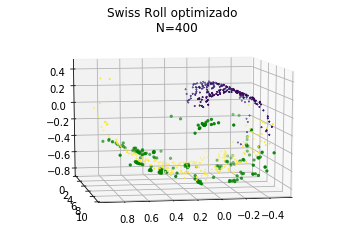

In [41]:
X_transported=res['x']
X_transported=X_transported.reshape(X_transported.shape[0]//dimension,dimension)
 
dat=X_transported#el resultado
data2=xinit.reshape(-1,dimension)#el dato inicial



fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 80)
ax.scatter(xs=dat[:,0], ys=dat[:,1], zs=dat[:,2], c='g', s=5)
ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2],marker='x',c=labels, s=1)
ax.scatter(xs=data2[:,0], ys=data2[:,1], zs=data2[:,2],marker='x', s=1)
plt.title('Swiss Roll optimizado \n N=%s'%(data.shape[0]))

plt.show()

In [42]:
np.max([con['fun'](X_transported.flatten()) for con in cons])

0.0015561886865782526

## Probando que pasa con la euclidea, FALLA!!!


In [150]:
%%time
Nfeval=1
def callbackF(Xi):
    global Nfeval
    print ('Iteracion:'+ str(Nfeval)+',    f: '+str(costo_euclideo_2(Xi)[0]) )
    Nfeval += 1

    
def costo_euclideo_2(x):
    xposta=x.reshape(x.shape[0]//dimension,dimension)
    grad=np.zeros(x.shape)
    res=0
    for i in range(Zcol.shape[0]):
        res+=np.linalg.norm(Zcol[i,:]-xposta[i,:])
        grad[3*i]= (xposta[i,:]-Zcol[i,:])[0]
        grad[3*i+1]=(xposta[i,:]-Zcol[i,:])[1]
        grad[3*i+2]=(xposta[i,:]-Zcol[i,:])[2]
    return res,2*grad
    
xinit=Y

opt={"disp": True, "maxiter":100}

res = minimize(costo_euclideo_2, x0=xinit, jac=True,constraints=cons,options=opt, callback=callbackF)


Iteracion:1,    f: 558.7651333285279
Iteracion:2,    f: 3410.527027704526
Iteracion:3,    f: 5921.094926231768
Iteracion:4,    f: 3758.2786766271465
Iteracion:5,    f: 3991.442840353056
Iteracion:6,    f: 2129.306014098635
Iteracion:7,    f: 2723.691357996656
Iteracion:8,    f: 2184.95901180454
Iteracion:9,    f: 2051.5381792973994
Iteracion:10,    f: 1315.002076388719
Iteracion:11,    f: 1332.155798672027
Iteracion:12,    f: 1099.1341285721903
Iteracion:13,    f: 958.0732070326974
Iteracion:14,    f: 684.5427373948502
Iteracion:15,    f: 595.7986053140472
Iteracion:16,    f: 465.36778553645667
Iteracion:17,    f: 339.2488728587152
Iteracion:18,    f: 254.65586272865332
Iteracion:19,    f: 193.473222547887
Iteracion:20,    f: 180.06793600882716
Iteracion:21,    f: 177.96408893562509
Iteracion:22,    f: 176.89510573958142
Iteracion:23,    f: 176.33526055091463
Iteracion:24,    f: 176.04902236551072
Iteracion:25,    f: 175.92819723224017
Iteracion:26,    f: 175.86085194151934
Iteracion:2

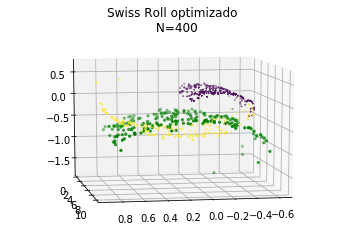

In [151]:
X_transported=res['x']
X_transported=X_transported.reshape(X_transported.shape[0]//dimension,dimension)
 
dat=X_transported#el resultado



fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 80)
ax.scatter(xs=dat[:,0], ys=dat[:,1], zs=dat[:,2], c='g', s=5)
ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2],marker='x',c=labels, s=1)
plt.title('Swiss Roll optimizado \n N=%s'%(data.shape[0]))

plt.show()

Con un punto inicial malo con euclideo

In [152]:
    
xinit=np.random.random(Y.shape)

opt={"disp": True, "maxiter":100}

res = minimize(costo_euclideo_2, x0=xinit, jac=True,constraints=cons,options=opt, callback=callbackF)


Iteracion:41,    f: 7622.802058370411
Iteracion:42,    f: 1188.209054414294
Iteracion:43,    f: 1223.1538303407285
Iteracion:44,    f: 2585.0027608117316
Iteracion:45,    f: 2406.5849130220054
Iteracion:46,    f: 819.2135214575657
Iteracion:47,    f: 625.2739277170172
Iteracion:48,    f: 580.9407931712551
Iteracion:49,    f: 366.12056870671677
Iteracion:50,    f: 262.6735692311464
Iteracion:51,    f: 235.84131998959148
Iteracion:52,    f: 196.95407442986448
Iteracion:53,    f: 183.91049762874883
Iteracion:54,    f: 179.53724031479092
Iteracion:55,    f: 177.5889364902806
Iteracion:56,    f: 176.6836627584807
Iteracion:57,    f: 176.23732775274354
Iteracion:58,    f: 176.01499439304865
Iteracion:59,    f: 175.90417348954017
Iteracion:60,    f: 175.84896787465104
Iteracion:61,    f: 175.821437633688
Iteracion:62,    f: 175.80768439207816
Iteracion:63,    f: 175.80080867666823
Iteracion:64,    f: 175.79737096791513
Iteracion:65,    f: 175.79565229610077
Iteracion:66,    f: 175.79479304938

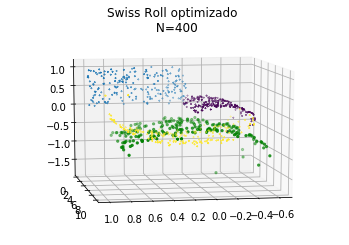

In [153]:
X_transported=res['x']
X_transported=X_transported.reshape(X_transported.shape[0]//dimension,dimension)

dat=X_transported#el resultado
data2=xinit.reshape(-1,dimension)#el dato inicial



fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 80)
ax.scatter(xs=dat[:,0], ys=dat[:,1], zs=dat[:,2], c='g', s=5)
ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2],marker='x',c=labels, s=1)
ax.scatter(xs=data2[:,0], ys=data2[:,1], zs=data2[:,2],marker='x', s=1)
plt.title('Swiss Roll optimizado \n N=%s'%(data.shape[0]))

plt.show()

#### Para probar la de fermat pero sin el gradiente (MUY lento):

In [127]:
%%time

xinit=np.random.random(xinit.shape)
opt={"maxiter": 3}
res = minimize(costo_sin_x_ni_grad, x0=xinit, constraints=cons,options=opt)
print(res)

     fun: 36140.988625885395
     jac: array([ 1.10400391e+00, -6.87622070e+01,  2.14433594e+01,  2.60742188e-01,
       -4.63867188e-02, -2.34375000e-02, -1.61132812e-02,  1.50878906e-01,
        1.70898438e-01,  1.71225586e+01, -3.28288086e+02,  7.79233398e+01,
        3.90625000e-01,  1.07421875e-01,  1.46386719e+00,  1.91992188e+00,
        8.10546875e-02,  8.49169922e+00,  5.54462891e+01, -3.71128906e+02,
        1.17324707e+02,  1.52319336e+01, -4.00499512e+02,  1.02004395e+02,
        3.96118164e+01, -3.69454590e+02,  1.00173828e+02,  5.69042969e+00,
       -2.10228516e+02,  4.95087891e+01,  1.83388672e+01, -4.00351562e+02,
        9.30224609e+01,  5.93750000e-01, -1.08575195e+02,  2.62177734e+01,
        2.69418945e+01, -2.27506348e+02,  4.57514648e+01,  5.57226562e+01,
       -3.07002930e+02,  1.14988281e+02,  1.51030273e+01, -2.68475586e+02,
        7.23037109e+01, -2.26562500e-01, -5.46386719e-01,  4.56201172e+00,
        1.41308594e+00, -4.00390625e-02,  1.30712891e+00,  8.

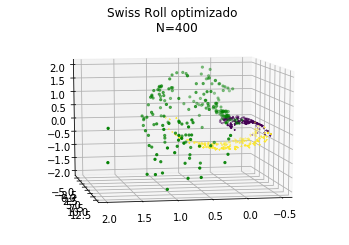

In [128]:
X_transported=res['x']
X_transported=X_transported.reshape(X_transported.shape[0]//dimension,dimension)

dat2=X_transported

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 80)
ax.scatter(xs=dat2[:,0], ys=dat2[:,1], zs=dat2[:,2], c='g', s=5)
ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2],marker='x',c=labels, s=1)
plt.title('Swiss Roll optimizado \n N=%s'%(data.shape[0]))

plt.show()

In [129]:
np.max(dat2-Ycol)

10.163579495444626

# Probando si tengo conocimiento de la superficie

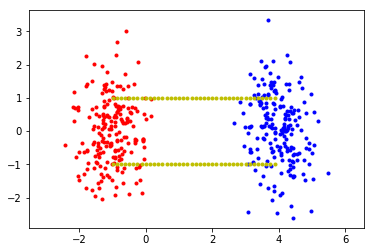

In [5]:
puntos=200
#Z son los iniciales
#Y son los objetivo
#x son los Z transformados, lo que voy a optimizar

#OJO GUARDO LA DATA COMO XY XY XY XY (no como XXXX YYYYY ) 

y1, y2 = np.random.multivariate_normal([4,0], [[0.3,0],[0,1]], puntos).T
y1=np.array(y1)
y2=np.array(y2)
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)

Ycol=np.concatenate((y1,y2),axis=1)
Y=Ycol.flatten()


x1, x2 = np.random.multivariate_normal([-1,0], [[0.3,0],[0,1]], puntos).T
x1=np.array(x1)
x2=np.array(x2)
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)
Zcol=np.concatenate((x1,x2),axis=1)
Z=Zcol.flatten()


top=np.ones((40,2))
bottom=-np.ones((40,2))
dx=5/top.shape[0]
for i in range(top.shape[0]):
    top[i,0]=i*dx-1
    bottom[i,0]=i*dx-1

plt.axis('equal')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(top[:,0],top[:,1],'.',c='y')
plt.plot(bottom[:,0],bottom[:,1],'.',c='y')



In [6]:
dimension=2 

alphaESP=2
kESP=10#cuanos vecinos miro para decidir la distancia a la que esta el nuevo punto
        
dataESP=np.concatenate((Zcol,Ycol,top,bottom),axis=0)
distanciasESP=np.matrix(distance_matrix(dataESP,dataESP))

modelESP=F.Fermat(alphaESP, path_method='FW')
modelESP.fit(distanciasESP)
distESP=modelESP.get_distances()
treeESP = KDTree(dataESP, leaf_size=2)

def costo_sin_x(x):
    
    xposta=x.reshape(x.shape[0]//dimension,dimension)
     
    res=0
    gradient=np.ones(x.shape)
    for i in range(Zcol.shape[0]):
        aux,grad_idx=distanciaFermat(i,xposta[i,:],distESP,treeESP,kESP) 
        res+=aux
        
        q=dataESP[grad_idx,:] #el ultimo mas cercano en el "mejor camino"
        grad=alphaESP*(np.linalg.norm(q-xposta[i,:])**(alphaESP-2))*(xposta[i,:]-q) #EL gradiente
        
        for coordenada in range(dimension):
            gradient[dimension*i+coordenada]=grad[coordenada]
    return res,gradient



def distanciaFermat(idx,end,dist,tree,k):
    d,ind=tree.query([end],k=k)
    d=np.power(d,alphaESP)
    ret=min([ dist[idx,ind[0,i]]+d[0,i] for i in range(d.shape[1])])
    
    indice=np.argmin([ dist[idx,ind[0,i]] for i in range(ind.shape[1])]) 
    
    grad_idx=ind[0,indice] #DEVUELVE EL INDICE DEL VECINO que esta a menor dist_fer de idx
    
    return ret,grad_idx



def costo_sin_x_ni_grad(x):
    
    xposta=x.reshape(x.shape[0]//dimension,dimension)
     
    res=0
    for i in range(Zcol.shape[0]):
        aux,grad_idx=distanciaFermat(i,xposta[i,:],distESP,treeESP,kESP) 
        res+=aux
    return res

In [7]:
A=np.zeros((dimension,dimension*puntos))

aux0=np.tile([1,0],puntos)
aux1=np.tile([0,1],puntos)
A[0,:]=aux0
A[1,:]=aux1

A=A/puntos
b=np.mean(Ycol,axis=0)

#RESTRICCIONES DE IGUALDAD
con1 = lambda x: np.dot(A[1,:], x) - b[1]
con0 = lambda x: np.dot(A[0,:], x ) - b[0]

A00 =  np.kron(np.eye(puntos),np.array([[1,0],[0,0]]))/puntos 
A01 =  np.kron(np.eye(puntos),np.array([[0,1],[0,0]]))/puntos 
A11 =  np.kron(np.eye(puntos),np.array([[0,0],[0,1]]))/puntos 


def con00(x):
    return (x@A00@x.T - Y@A00@Y.T ) 

def con01(x):
    return (x@A01@x.T - Y@A01@Y.T )                 
   
def con11(x):
    return (x@A11@x.T - Y@A11@Y.T )


cons = [{'type': 'eq', 'fun': con0,'jac': lambda x: A[0,:]},
        {'type': 'eq', 'fun': con1,'jac': lambda x: A[1,:]},
        {'type': 'eq', 'fun': con00,'jac': lambda x: 2*A00@x.T},
        {'type': 'eq', 'fun': con01,'jac': lambda x: 2*A01@x.T},
        {'type': 'eq', 'fun': con11,'jac': lambda x: 2*A11@x.T} ]


#LINEAR CONSTRAINTS
#eps=0.1*np.ones(b.shape)
#cons = LinearConstraint(A,b-eps,b+eps)
#cons=LinearConstraint(A,b,b)

#XINICIAL, QUE VA
xinit = Y

#ACA PUEDO PONER OPCIONES
opt={"disp": True, "maxiter":500}

In [143]:
%%time
Nfeval=1
def callbackF(Xi):
    global Nfeval
    print ('Iteracion:'+ str(Nfeval)+',    f: '+str(costo_sin_x(Xi)[0]) )
    Nfeval += 1
    
res = minimize(costo_sin_x, x0=xinit,jac=True, constraints=cons,options=opt,callback=callbackF)
print(res)

Iteracion:1,    f: 176.00501901587984
Iteracion:2,    f: 201.26659064712
Iteracion:3,    f: 181.38898110708348
Iteracion:4,    f: 173.73720874695928
Iteracion:5,    f: 188.33892100539254
Iteracion:6,    f: 169.85086673039794
Iteracion:7,    f: 163.44360545075972
Iteracion:8,    f: 160.0437052664846
Iteracion:9,    f: 159.07659362170432
Iteracion:10,    f: 158.43801500810565
Iteracion:11,    f: 158.23745101561914
Iteracion:12,    f: 157.3013880226918
Iteracion:13,    f: 156.79329663888575
Iteracion:14,    f: 156.92873773745296
Iteracion:15,    f: 156.73030509007845
Iteracion:16,    f: 159.12870930767963
Iteracion:17,    f: 156.202337767459
Iteracion:18,    f: 156.37499072175765
Iteracion:19,    f: 156.11859188349806
Iteracion:20,    f: 156.71718692479158
Iteracion:21,    f: 156.1396960279866
Iteracion:22,    f: 167.13648624004742
Iteracion:23,    f: 156.1365296336919
Iteracion:24,    f: 156.17746358028793
Iteracion:25,    f: 156.12640355425572
Iteracion:26,    f: 156.19374505223354
Iter

Iteracion:211,    f: 156.11500459797168
Iteracion:212,    f: 156.11871760383926
Iteracion:213,    f: 156.11533022869997
Iteracion:214,    f: 156.11852649997013
Iteracion:215,    f: 156.11562421727004
Iteracion:216,    f: 91714.25694167109
Iteracion:217,    f: 156.163516035041
Iteracion:218,    f: 156.0987715869838
Iteracion:219,    f: 156.12795862478126
Iteracion:220,    f: 156.10508138195468
Iteracion:221,    f: 156.12339171612092
Iteracion:222,    f: 156.10692827714252
Iteracion:223,    f: 156.12179622415744
Iteracion:224,    f: 156.10793697781148
Iteracion:225,    f: 156.12136887659292
Iteracion:226,    f: 156.10870729366587
Iteracion:227,    f: 156.12151984285575
Iteracion:228,    f: 156.10931642779767
Iteracion:229,    f: 156.12123064453795
Iteracion:230,    f: 156.10984833041115
Iteracion:231,    f: 156.12035550653246
Iteracion:232,    f: 156.1105348293571
Iteracion:233,    f: 156.11893182463504
Iteracion:234,    f: 156.11226515088416
Iteracion:235,    f: 156.11680622076315
Itera

Iteracion:418,    f: 156.1809781813576
Iteracion:419,    f: 156.16871034278492
Iteracion:420,    f: 156.17975215579054
Iteracion:421,    f: 156.1695183988167
Iteracion:422,    f: 156.17803317372426
Iteracion:423,    f: 156.1708687689791
Iteracion:424,    f: 156.17632641947108
Iteracion:425,    f: 156.17254368246475
Iteracion:426,    f: 156.1747628620536
Iteracion:427,    f: 156.1744747659285
Iteracion:428,    f: 156.17335865510518
Iteracion:429,    f: 156.1765694181404
Iteracion:430,    f: 156.172164932678
Iteracion:431,    f: 156.17845617289106
Iteracion:432,    f: 156.17128308903457
Iteracion:433,    f: 156.17949455518252
Iteracion:434,    f: 156.17080587611795
Iteracion:435,    f: 156.17937366012555
Iteracion:436,    f: 156.17077308262822
Iteracion:437,    f: 156.17848749363824
Iteracion:438,    f: 156.1711199508644
Iteracion:439,    f: 156.17741671414416
Iteracion:440,    f: 156.17169031372725
Iteracion:441,    f: 156.17646642542326
Iteracion:442,    f: 156.1723404661917
Iteracion:

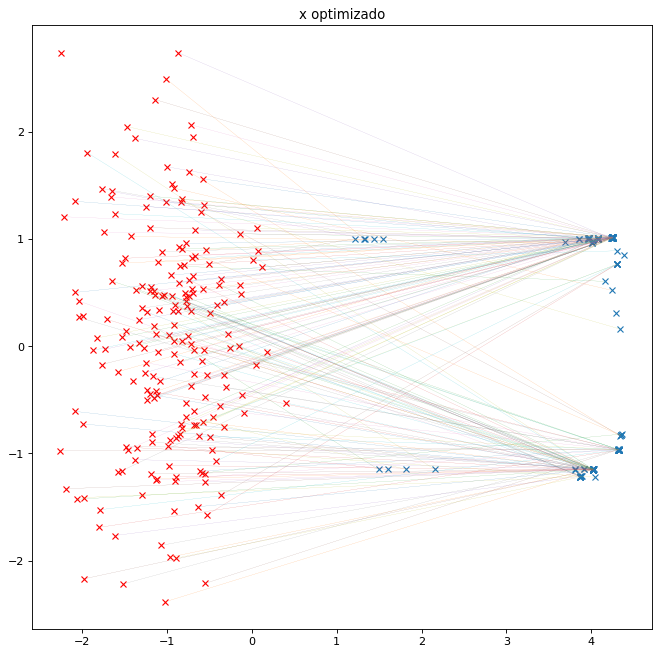

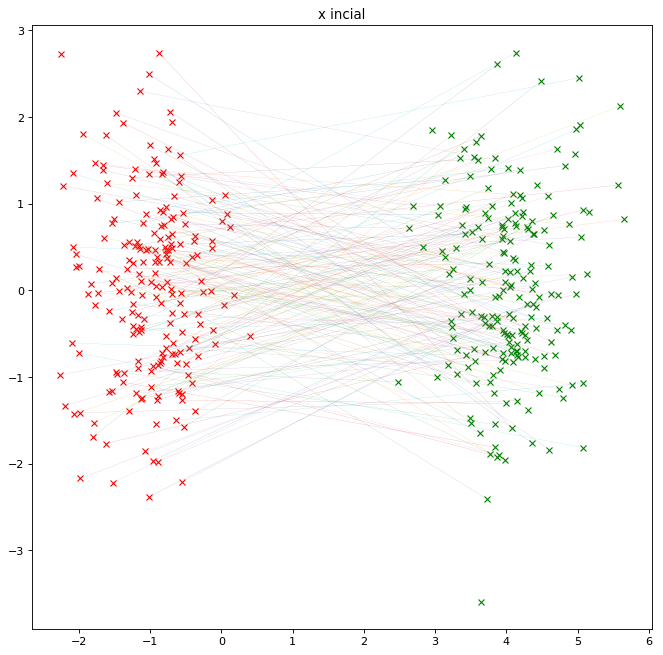

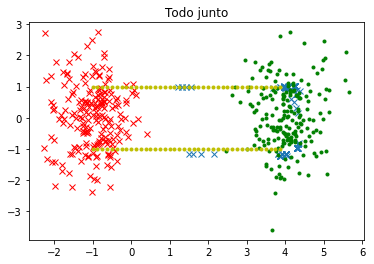

In [144]:
X_transported=res['x']
X_t=X_transported.reshape(-1,dimension)

percent=0.9 #PORCENTAJE DE LINEAS QUE PLOTEO



from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
x=X_t[:,0]
y=X_t[:,1]
plt.plot(x,y,'x')
plt.plot(x1,x2,'x',c='r')
#plt.plot(y1,y2,'.',c='g')
for i in range(int(len(x)*percent)):
    plt.plot([x1[i],x[i]],[x2[i],y[i]],lw=0.1)
plt.title('x optimizado')
plt.show()
#plt.plot([2,1],[4,4])



figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
inicial=xinit.reshape(-1,dimension)
plt.plot(x1,x2,'x',c='r')
plt.plot(inicial[:,0],inicial[:,1],'x',c='g')
for i in range(int(len(x)*percent)):
    plt.plot([x1[i],inicial[i,0]],[x2[i],inicial[i,1]],lw=0.1)

plt.title('x incial')
plt.show()



plt.plot(x,y,'x')
plt.plot(x1,x2,'x',c='r')
plt.plot(inicial[:,0],inicial[:,1],'.',c='g')
plt.plot(top[:,0],top[:,1],'.',c='y')
plt.plot(bottom[:,0],bottom[:,1],'.',c='y')
plt.title('Todo junto')
plt.show()

#### Probamos ahora empezando con un x inicial cualquiera, O CON EL MISMO Z para que no pasen cosas raras de a quien matchea con quien

In [145]:
%%time
Nfeval=1
def callbackF(Xi):
    global Nfeval
    print ('Iteracion:'+ str(Nfeval)+',    f: '+str(costo_sin_x(Xi)[0]) )
    Nfeval += 1
    
xinit=np.random.random(Y.shape)
xinit=Z

#opt["maxiter"]=20

res = minimize(costo_sin_x, x0=xinit,jac=True, constraints=cons,options=opt,callback=callbackF)
print(res)

Iteracion:1,    f: 91195.85643774296
Iteracion:2,    f: 2537.7641894911253
Iteracion:3,    f: 1231.3292448930479
Iteracion:4,    f: 509.94045484128276
Iteracion:5,    f: 481.1361235838542
Iteracion:6,    f: 570.2217982949813
Iteracion:7,    f: 356.38910081137095
Iteracion:8,    f: 232.73233324615148
Iteracion:9,    f: 172.85937887993887
Iteracion:10,    f: 159.28557420086057
Iteracion:11,    f: 159.44648212975378
Iteracion:12,    f: 152.75818787704208
Iteracion:13,    f: 151.56780960645136
Iteracion:14,    f: 149.7159709721399
Iteracion:15,    f: 148.793251747927
Iteracion:16,    f: 148.21661220501196
Iteracion:17,    f: 148.24082143335588
Iteracion:18,    f: 148.11067490790953
Iteracion:19,    f: 148.02515242960308
Iteracion:20,    f: 148.3479579957304
Iteracion:21,    f: 147.9526351357079
Iteracion:22,    f: 147.69398770753347
Iteracion:23,    f: 147.5649815750459
Iteracion:24,    f: 147.4570853018375
Iteracion:25,    f: 147.4813918436404
Iteracion:26,    f: 147.5205662825145
Iteraci

Iteracion:211,    f: 147.38366266948452
Iteracion:212,    f: 147.38435759567912
Iteracion:213,    f: 147.38376771898422
Iteracion:214,    f: 147.38415650754922
Iteracion:215,    f: 147.38391249903296
Iteracion:216,    f: 147.38394288356662
Iteracion:217,    f: 147.3840721031561
Iteracion:218,    f: 147.38372851422608
Iteracion:219,    f: 147.38422632178032
Iteracion:220,    f: 147.38351175753994
Iteracion:221,    f: 147.38436160003567
Iteracion:222,    f: 147.38332633880515
Iteracion:223,    f: 147.38446501424357
Iteracion:224,    f: 147.38317889639188
Iteracion:225,    f: 147.38455591397172
Iteracion:226,    f: 147.38307311797746
Iteracion:227,    f: 147.38461777352902
Iteracion:228,    f: 147.38301300783925
Iteracion:229,    f: 147.38466054700265
Iteracion:230,    f: 147.38300753078533
Iteracion:231,    f: 147.38468369049815
Iteracion:232,    f: 147.38305843639642
Iteracion:233,    f: 147.3846770177654
Iteracion:234,    f: 147.38317573260605
Iteracion:235,    f: 147.38461523819385
It

Iteracion:418,    f: 147.38773313438162
Iteracion:419,    f: 147.38673546957642
Iteracion:420,    f: 147.38793852273056
Iteracion:421,    f: 147.38655107661526
Iteracion:422,    f: 147.38809287718848
Iteracion:423,    f: 147.38642937896938
Iteracion:424,    f: 147.38817003590017
Iteracion:425,    f: 147.38637554845232
Iteracion:426,    f: 147.38816128250966
Iteracion:427,    f: 147.38638620884595
Iteracion:428,    f: 147.388079874025
Iteracion:429,    f: 147.38645113329392
Iteracion:430,    f: 147.3879510105121
Iteracion:431,    f: 147.38655879925702
Iteracion:432,    f: 147.38779744363478
Iteracion:433,    f: 147.3867026611692
Iteracion:434,    f: 147.3876317791672
Iteracion:435,    f: 147.38688512327516
Iteracion:436,    f: 147.38745689985166
Iteracion:437,    f: 147.38711717391035
Iteracion:438,    f: 147.3872710673118
Iteracion:439,    f: 147.38740945386
Iteracion:440,    f: 147.38707485670014
Iteracion:441,    f: 147.3877475676156
Iteracion:442,    f: 147.38687678162654
Iteracion:

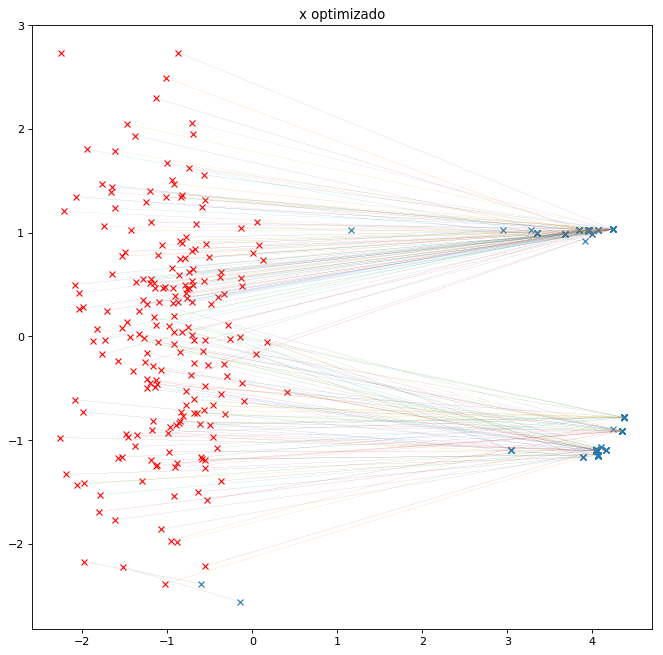

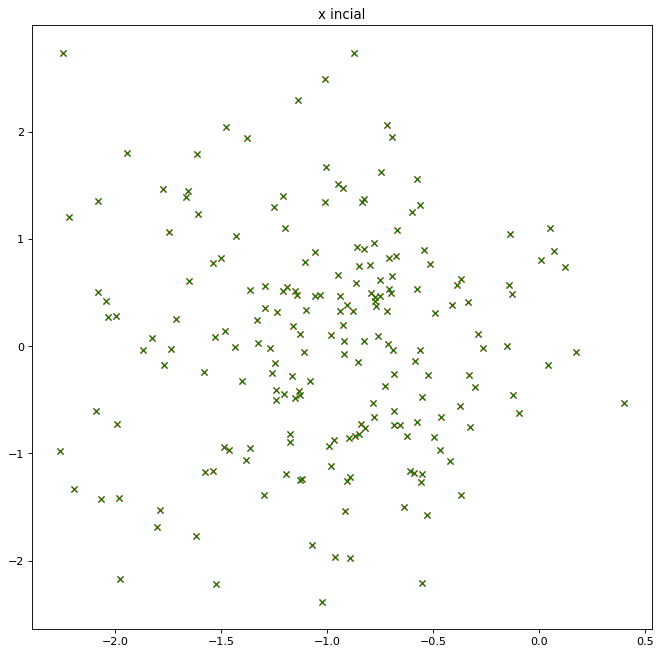

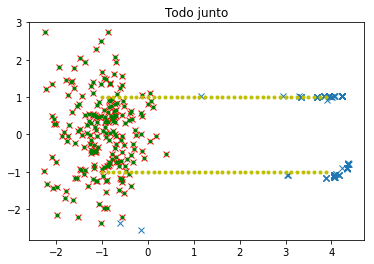

In [146]:
X_transported=res['x']
X_t=X_transported.reshape(-1,dimension)

percent=0.9

from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')



x=X_t[:,0]
y=X_t[:,1]
plt.plot(x,y,'x')
plt.plot(x1,x2,'x',c='r')
#plt.plot(y1,y2,'.',c='g')
for i in range(int(len(x)*percent)):
    plt.plot([x1[i],x[i]],[x2[i],y[i]],lw=0.1)
plt.title('x optimizado')
plt.show()
#plt.plot([2,1],[4,4])


figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

inicial=xinit.reshape(-1,dimension)
plt.plot(x1,x2,'x',c='r')
plt.plot(inicial[:,0],inicial[:,1],'x',c='g')
for i in range(int(len(x)*percent)):
    plt.plot([x1[i],inicial[i,0]],[x2[i],inicial[i,1]],lw=0.1)

plt.title('x incial')
plt.show()



plt.plot(x,y,'x')
plt.plot(x1,x2,'x',c='r')
plt.plot(inicial[:,0],inicial[:,1],'.',c='g')
plt.plot(top[:,0],top[:,1],'.',c='y')
plt.plot(bottom[:,0],bottom[:,1],'.',c='y')
plt.title('Todo junto')
plt.show()

#### POnemos como x inicial  algo cualquiera.

In [11]:
%%time
Nfeval=1
def callbackF(Xi,d):
    global Nfeval
    print ('Iteracion:'+ str(Nfeval)+',    f: '+str(costo_sin_x(Xi)[0]) )
    Nfeval += 1
    
xinit=np.ones(Y.shape)*6

#opt["maxiter"]=20

res = minimize(costo_sin_x, x0=xinit,jac=True,method='trust-constr', constraints=cons,options=opt,callback=callbackF)
print(res)

/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:1,    f: 3108.367963195379


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:2,    f: 3029.807395526426


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:3,    f: 2906.6152332310357


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:4,    f: 2715.9216839186392


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:5,    f: 2427.2386280553887


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:6,    f: 2007.4248813572874


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:7,    f: 1443.539177896863


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:8,    f: 817.5242006204643


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:9,    f: 436.47962460481585


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:10,    f: 948.4157645086206


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:11,    f: 948.4157645086206


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:12,    f: 376.4996195558957


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:13,    f: 376.4996195558957


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:14,    f: 450.63725710753397


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:15,    f: 450.63725710753397


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:16,    f: 421.3120409732549


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:17,    f: 421.3120409732549


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:18,    f: 310.82142319418773


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:19,    f: 212.18225486452872


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:20,    f: 176.26372764842034


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:21,    f: 159.08848675362637


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:22,    f: 157.14138584415235


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:23,    f: 157.14138584415235


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:24,    f: 157.14138584415235


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:25,    f: 156.22596574909235


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:26,    f: 156.22596574909235


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:27,    f: 155.55621544404337


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:28,    f: 155.2365131627383


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:29,    f: 155.33050808686474


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:30,    f: 155.29918773478843


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:31,    f: 155.31968839367343


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:32,    f: 155.64003851833485


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:33,    f: 155.64003851833485


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:34,    f: 155.64003851833485


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:35,    f: 155.64003851833485


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:36,    f: 155.64003851833485


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:37,    f: 155.63630063344633


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:38,    f: 155.63263775504723


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:39,    f: 155.62902927107422


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:40,    f: 155.62547456863285


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:41,    f: 155.62197348995346


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:42,    f: 155.61852599095855


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:43,    f: 155.6151320558956


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:44,    f: 155.6117916759937


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:45,    f: 155.6117916759937


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:46,    f: 155.61010058033514


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:47,    f: 155.61010058033514


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:48,    f: 155.60866886228257


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:49,    f: 155.60724992599899


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:50,    f: 155.60584147992898


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:51,    f: 155.60444295010748


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:52,    f: 155.60305419247362


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:53,    f: 155.60167517045093


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:54,    f: 155.60030587432473


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:55,    f: 155.59894630108815


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:56,    f: 155.59759644940596


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:57,    f: 155.5962563183546


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:58,    f: 155.59492590710767


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:59,    f: 155.593605214858


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:60,    f: 155.59229424079624


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:61,    f: 155.59099298410732


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:62,    f: 155.58970144396864


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:63,    f: 155.58841961954903


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:64,    f: 155.58714751000943


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:65,    f: 155.58588511450264


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:66,    f: 155.58463243217247


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:67,    f: 155.58338946215434


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:68,    f: 155.58215620357478


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:69,    f: 155.58093265555183


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:70,    f: 155.57982648295015


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:71,    f: 155.5787306425147


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:72,    f: 155.57764464709578


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:73,    f: 155.5765683740425


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:74,    f: 155.5755017918144


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:75,    f: 155.57444489163626


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:76,    f: 155.57339767041373


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:77,    f: 155.572343467922


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:78,    f: 155.57129540254496


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:79,    f: 155.57024501597812


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:80,    f: 155.5691845116279


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:81,    f: 155.56813362983027


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:82,    f: 155.56709236908748


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:83,    f: 155.5660493511383


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:84,    f: 155.56490310413673


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:85,    f: 155.5636490148575


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:86,    f: 155.5623688483441


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:87,    f: 155.56106592402824


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:88,    f: 155.55977268467606


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:89,    f: 155.5584891291573


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:90,    f: 155.55721525632808


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:91,    f: 155.55595106503313


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:92,    f: 155.55469655410408


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:93,    f: 155.5534517223601


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:94,    f: 155.55221656860698


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:95,    f: 155.5509910916373


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:96,    f: 155.5497752902309


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:97,    f: 155.54856916315308


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:98,    f: 155.54737270915587


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:99,    f: 155.54618592697716


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:100,    f: 155.5450088153401


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:101,    f: 155.5438413729535


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:102,    f: 155.5426835985114


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:103,    f: 155.54153549069298


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:104,    f: 155.54039704816137


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:105,    f: 155.53926826956481


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:106,    f: 155.5381491535353


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:107,    f: 155.53703969868874


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:108,    f: 155.53593990362486


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:109,    f: 155.53484976692587


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:110,    f: 155.53372230654173


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:111,    f: 155.5325689219371


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:112,    f: 155.5314251842058


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:113,    f: 155.53029109182833


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:114,    f: 155.52916664326656


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:115,    f: 155.52805183696367


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:116,    f: 155.52694667134338


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:117,    f: 155.52585114480945


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:118,    f: 155.52476525574573


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:119,    f: 155.5236890025156


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:120,    f: 155.52262238346157


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:121,    f: 155.52156539690483


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:122,    f: 155.52051804114478


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:123,    f: 155.519480314459


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:124,    f: 155.5184522151024


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:125,    f: 155.51743374130686


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:126,    f: 155.51642489128062


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:127,    f: 155.51542566320887


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:128,    f: 155.51443605525128


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:129,    f: 155.51345606554335


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:130,    f: 155.51248569219507


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:131,    f: 155.51152493329036


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:132,    f: 155.51057378688677


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:133,    f: 155.5096322510151


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:134,    f: 155.50870032367817


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:135,    f: 155.50777800285078


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:136,    f: 155.5067978123268


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:137,    f: 155.5067978123268


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:138,    f: 155.506359700968


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:139,    f: 155.506359700968


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:140,    f: 155.50603138597467


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:141,    f: 155.5057068098712


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:142,    f: 155.50538393157302


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:143,    f: 155.5050622400978


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:144,    f: 155.50474160765407


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:145,    f: 155.50442200225658


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:146,    f: 155.50410341586493


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:147,    f: 155.50378584642232


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:148,    f: 155.50346929336652


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:149,    f: 155.50315375650905


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:150,    f: 155.5028392357542


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:151,    f: 155.50252573102964


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:152,    f: 155.50221324226814


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:153,    f: 155.50190176940382


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:154,    f: 155.50159131237132


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:155,    f: 155.50128187110397


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:156,    f: 155.50094748107145


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:157,    f: 155.50061415946539


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:158,    f: 155.5002818663322


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:159,    f: 155.49995059163933


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:160,    f: 155.49962033283143


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:161,    f: 155.4992910892215


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:162,    f: 155.49896286058956


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:163,    f: 155.4986356468315


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:164,    f: 155.49830944787257


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:165,    f: 155.49798426364438


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:166,    f: 155.4976600940805


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:167,    f: 155.4973369391147


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:168,    f: 155.49701479868023


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:169,    f: 155.49669367271048


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:170,    f: 155.49637356113806


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:171,    f: 155.4960544638955


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:172,    f: 155.49573638091502


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:173,    f: 155.49541931212866


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:174,    f: 155.49510325746766


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:175,    f: 155.4947882168637


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:176,    f: 155.4944741902473


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:177,    f: 155.494161177549


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:178,    f: 155.4938491786992


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:179,    f: 155.49353819362796


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:180,    f: 155.49322822226443


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:181,    f: 155.49291926453816


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:182,    f: 155.49261132037785


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:183,    f: 155.4923043897119


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:184,    f: 155.49199847246885


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:185,    f: 155.49169356857632


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:186,    f: 155.49138967796176


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:187,    f: 155.49108680055252


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:188,    f: 155.490784936275


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:189,    f: 155.49048408505578


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:190,    f: 155.49018424682083


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:191,    f: 155.4898854214959


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:192,    f: 155.48958760900604


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:193,    f: 155.48929080927664


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:194,    f: 155.48899502223176


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:195,    f: 155.48870024779595


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:196,    f: 155.48840648589265


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:197,    f: 155.48811373644523


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:198,    f: 155.48782199937716


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:199,    f: 155.48753127461066


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:200,    f: 155.487241562068


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:201,    f: 155.48695286167126


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:202,    f: 155.4866651733414


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:203,    f: 155.48637849699992


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:204,    f: 155.4860928325671


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:205,    f: 155.48580817996339


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:206,    f: 155.48552453910852


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:207,    f: 155.48524190992177


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:208,    f: 155.48496029232214


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:209,    f: 155.48467968622828


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:210,    f: 155.48440009155806


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:211,    f: 155.48412150822935


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:212,    f: 155.48384393615956


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:213,    f: 155.48356737526515


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:214,    f: 155.4832918254626


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:215,    f: 155.483017286668


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:216,    f: 155.48274375879683


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:217,    f: 155.4824712417637


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:218,    f: 155.48219973548387


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:219,    f: 155.48192923987096


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:220,    f: 155.4816597548387


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:221,    f: 155.48139128030058


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:222,    f: 155.4811238161689


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:223,    f: 155.48085736235632


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:224,    f: 155.48059191877434


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:225,    f: 155.48032748533433


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:226,    f: 155.4800640619471


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:227,    f: 155.47980164852282


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:228,    f: 155.47954024497173


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:229,    f: 155.4792798512025


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:230,    f: 155.4790204671248


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:231,    f: 155.47876209264643


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:232,    f: 155.47850472767507


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:233,    f: 155.47824837211846


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:234,    f: 155.47799302588297


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:235,    f: 155.47773868887518


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:236,    f: 155.4774853610006


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:237,    f: 155.47723304216453


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:238,    f: 155.47698173227164


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:239,    f: 155.47673143122614


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:240,    f: 155.47648213893123


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:241,    f: 155.47623385529033


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:242,    f: 155.4759865802057


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:243,    f: 155.4757403135793


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:244,    f: 155.4754950553123


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:245,    f: 155.47525080530582


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:246,    f: 155.4750075634599


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:247,    f: 155.47476532967391


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:248,    f: 155.47452410384707


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:249,    f: 155.47428388587815


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:250,    f: 155.4740446756643


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:251,    f: 155.47380647310342


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:252,    f: 155.47356927809173


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:253,    f: 155.47333309052522


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:254,    f: 155.4730979102995


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:255,    f: 155.47286373730913


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:256,    f: 155.47263057144852


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:257,    f: 155.47239841261106


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:258,    f: 155.47216726068947


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:259,    f: 155.47193711557622


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:260,    f: 155.4717079771625


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:261,    f: 155.4714798453398


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:262,    f: 155.47125271999786


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:263,    f: 155.47102660102638


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:264,    f: 155.4708014883142


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:265,    f: 155.47057738174973


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:266,    f: 155.47035428122035


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:267,    f: 155.4701321866128


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:268,    f: 155.4699110978134


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:269,    f: 155.4696910147074


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:270,    f: 155.4694719371794


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:271,    f: 155.46925386511361


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:272,    f: 155.46903679839303


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:273,    f: 155.4688207369003


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:274,    f: 155.46860568051707


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:275,    f: 155.46839162912445


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:276,    f: 155.46817858260255


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:277,    f: 155.4679665408308


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:278,    f: 155.46775550368798


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:279,    f: 155.4675454710521


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:280,    f: 155.46733644280005


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:281,    f: 155.46712841880822


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:282,    f: 155.4669213989523


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:283,    f: 155.46671538310684


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:284,    f: 155.4665103711454


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:285,    f: 155.46630636294142


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:286,    f: 155.46610335836723


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:287,    f: 155.46590135729383


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:288,    f: 155.46570035959198


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:289,    f: 155.46550036513088


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:290,    f: 155.46530137377974


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:291,    f: 155.46510338540628


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:292,    f: 155.46490639987744


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:293,    f: 155.46471041705945


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:294,    f: 155.4645154368173


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:295,    f: 155.46432145901522


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:296,    f: 155.4641284835168


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:297,    f: 155.46393651018408


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:298,    f: 155.46374553887867


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:299,    f: 155.46355556946102


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:300,    f: 155.46336660179054


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:301,    f: 155.4631786357259


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:302,    f: 155.46299167112466


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:303,    f: 155.46280570784305


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:304,    f: 155.46262074573687


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:305,    f: 155.4624367846604


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:306,    f: 155.46225382446738


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:307,    f: 155.4620718650099


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:308,    f: 155.46189090613964


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:309,    f: 155.4617109477065


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:310,    f: 155.46153198955983


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:311,    f: 155.46135403154787


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:312,    f: 155.46117707351766


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:313,    f: 155.46100111531487


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:314,    f: 155.46082615678438


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:315,    f: 155.4606521977698


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:316,    f: 155.46047923811366


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:317,    f: 155.46030727765708


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:318,    f: 155.46013631624027


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:319,    f: 155.45996635370213


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:320,    f: 155.4597973898804


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:321,    f: 155.45962942461153


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:322,    f: 155.45946245773072


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:323,    f: 155.45929648907207


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:324,    f: 155.45913151846835


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:325,    f: 155.45896754575082


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:326,    f: 155.45880457074975


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:327,    f: 155.4586425932941


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:328,    f: 155.45848161321126


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:329,    f: 155.45832163032725


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:330,    f: 155.45816264446702


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:331,    f: 155.4580046554542


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:332,    f: 155.45784766311053


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:333,    f: 155.45769166725688


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:334,    f: 155.4575366677124


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:335,    f: 155.457382664295


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:336,    f: 155.4572296568205


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:337,    f: 155.45707764510433


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:338,    f: 155.45692662895945


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:339,    f: 155.45677660819786


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:340,    f: 155.45662758262978


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:341,    f: 155.45647955206414


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:342,    f: 155.45633251630775


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:343,    f: 155.45618144505886


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:344,    f: 155.45602173645366


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:345,    f: 155.4558597301895


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:346,    f: 155.4556728535222


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:347,    f: 155.45548653133713


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:348,    f: 155.45528608968482


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:349,    f: 155.45506987983572


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:350,    f: 155.45482463815347


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:351,    f: 155.45456713226042


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:352,    f: 155.4543106587382


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:353,    f: 155.45405521755282


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:354,    f: 155.45380080866994


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:355,    f: 155.45354743205496


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:356,    f: 155.45329508767318


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:357,    f: 155.45304377548902


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:358,    f: 155.45279349546763


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:359,    f: 155.45254424757294


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:360,    f: 155.45229603176932


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:361,    f: 155.4520488480207


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:362,    f: 155.45180269629017


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:363,    f: 155.45155757654163


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:364,    f: 155.45131348873792


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:365,    f: 155.45107043284133


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:366,    f: 155.45082840881503


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:367,    f: 155.45058741662086


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:368,    f: 155.4503474562208


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:369,    f: 155.4501085275762


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:370,    f: 155.4498706306485


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:371,    f: 155.44963376539874


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:372,    f: 155.44939793178776


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:373,    f: 155.4491631297758


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:374,    f: 155.448929359323


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:375,    f: 155.44869662038883


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:376,    f: 155.44846491293322


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:377,    f: 155.44823423691489


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:378,    f: 155.44800459229282


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:379,    f: 155.44777597902544


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:380,    f: 155.44754839707068


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:381,    f: 155.44732184638684


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:382,    f: 155.44709632693053


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:383,    f: 155.44687183865946


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:384,    f: 155.4466140701944


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:385,    f: 155.44633441775247


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:386,    f: 155.44605579490442


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:387,    f: 155.4457782016053


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:388,    f: 155.445501637809


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:389,    f: 155.44522610346968


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:390,    f: 155.4449515985409


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:391,    f: 155.44467812297597


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:392,    f: 155.44440567672754


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:393,    f: 155.44413425974813


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:394,    f: 155.44386387198966


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:395,    f: 155.443594513404


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:396,    f: 155.44332618394225


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:397,    f: 155.4430588835553


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:398,    f: 155.44279261219356


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:399,    f: 155.44252736980718


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:400,    f: 155.4422631563457


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:401,    f: 155.44199997175815


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:402,    f: 155.44173781599346


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:403,    f: 155.44147668899987


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:404,    f: 155.44121659072508


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:405,    f: 155.44095752111673


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:406,    f: 155.4406994801217


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:407,    f: 155.44044246768624


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:408,    f: 155.44018648375652


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:409,    f: 155.439931528278


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:410,    f: 155.43967760119583


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:411,    f: 155.43942470245435


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:412,    f: 155.4391728319978


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:413,    f: 155.43892198976934


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:414,    f: 155.43867217571238


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:415,    f: 155.43842338976916


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:416,    f: 155.4381756318816


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:417,    f: 155.43792890199106


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:418,    f: 155.43768320003875


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:419,    f: 155.43743852596432


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:420,    f: 155.43719487970802


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:421,    f: 155.43695226120866


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:422,    f: 155.43671067040478


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:423,    f: 155.43647010723475


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:424,    f: 155.4362305716355


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:425,    f: 155.4359920635437


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:426,    f: 155.43575458289573


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:427,    f: 155.43551812962676


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:428,    f: 155.43528270367176


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:429,    f: 155.4350483049649


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:430,    f: 155.43481493343967


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:431,    f: 155.43458258902874


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:432,    f: 155.43435127166416


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:433,    f: 155.43412098127763


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:434,    f: 155.4338917177995


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:435,    f: 155.43366348115995


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:436,    f: 155.43343627128792


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:437,    f: 155.43321008811213


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:438,    f: 155.43298493156001


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:439,    f: 155.43276080155874


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:440,    f: 155.43253769803417


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:441,    f: 155.43231562091148


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:442,    f: 155.43209457011542


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:443,    f: 155.43187454556937


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:444,    f: 155.4316555471962


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:445,    f: 155.43143757491765


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:446,    f: 155.43122062865473


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:447,    f: 155.43100470832744


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:448,    f: 155.43078981385503


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:449,    f: 155.4305759451558


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:450,    f: 155.43036310214669


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:451,    f: 155.4301512847441


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:452,    f: 155.4299404928631


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:453,    f: 155.42973072641817


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:454,    f: 155.4295219853223


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:455,    f: 155.42931426948755


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:456,    f: 155.42910757882487


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:457,    f: 155.42890191324446


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:458,    f: 155.42869727265474


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:459,    f: 155.42849365696364


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:460,    f: 155.4282910660773


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:461,    f: 155.42808949990095


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:462,    f: 155.42783527761512


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:463,    f: 155.42757929783264


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:464,    f: 155.42732439126758


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:465,    f: 155.42707055826227


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:466,    f: 155.4268177991652


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:467,    f: 155.42656611433162


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:468,    f: 155.42631550412386


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:469,    f: 155.42606596891181


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:470,    f: 155.425817509072


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:471,    f: 155.4255701249888


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:472,    f: 155.42532381705496


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:473,    f: 155.4250785856705


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:474,    f: 155.4248344312442


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:475,    f: 155.42459135419318


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:476,    f: 155.42434935494347


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:477,    f: 155.42410843393017


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:478,    f: 155.42386859159748


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:479,    f: 155.4236298284


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:480,    f: 155.4233921448012


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:481,    f: 155.42315554127578


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:482,    f: 155.42292001830867


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:483,    f: 155.42268557639585


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:484,    f: 155.4224522160442


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:485,    f: 155.4222199377733


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:486,    f: 155.4219887421137


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:487,    f: 155.42175862960943


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:488,    f: 155.4215296008171


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:489,    f: 155.42130165630635


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:490,    f: 155.42107479666177


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:491,    f: 155.4208490224812


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:492,    f: 155.4206243343782


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:493,    f: 155.42040073298134


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:494,    f: 155.42017821893546


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:495,    f: 155.4199567929022


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:496,    f: 155.4197364555603


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:497,    f: 155.41951720760636


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:498,    f: 155.41929904975598


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:499,    f: 155.41908198274376


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:500,    f: 155.4188660073249


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:501,    f: 155.41865112427547
The maximum number of function evaluations is exceeded.
Number of iterations: 501, function evaluations: 971, CG iterations: 539, optimality: 3.03e-02, constraint violation: 1.35e-06, execution time: 1.7e+03 s.
         cg_niter: 539
     cg_stop_cond: 2
           constr: [array([0.]), array([-1.38777878e-17]), array([3.38928885e-12]), array([1.34923162e-06]), array([0.])]
      constr_nfev: [971, 971, 971, 971, 971]
      constr_nhev: [0, 0, 0, 0, 0]
      constr_njev: [971, 971, 971, 971, 971]
   constr_penalty: 3349.081077715639
 constr_violation: 1.349231618152924e-06
   execution_time: 1679.0510528087616
              fun: 155.41865112427547
             grad: array([ 0.90343983,  0.17608067,  0.92113813, -0.14241469,  0.4708778 ,
        0.14926148,  0.4539297 , -0.14411691,  0.47087017,  0.14926148,
        0.47087017,  0.14926148,  0.47100013,  0.14600197,  0.47100013,
        0.14600197,  0.51278325, -0.13884469,  0.45431432, -0.1470190

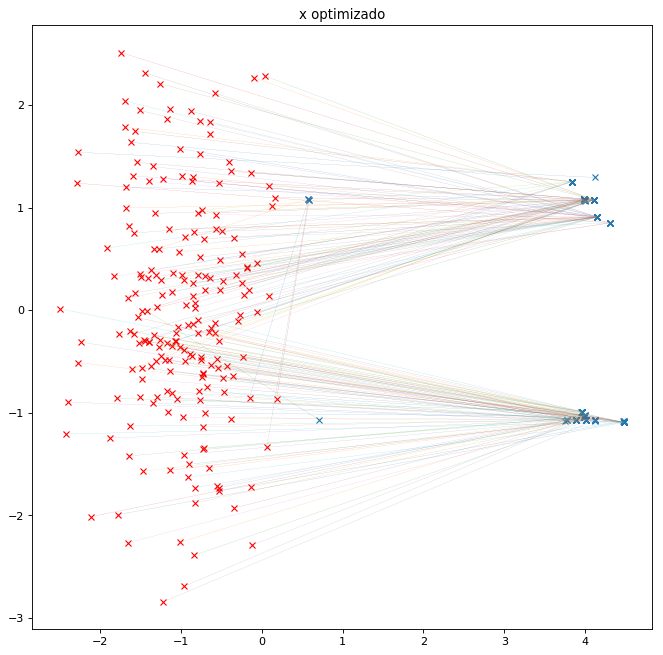

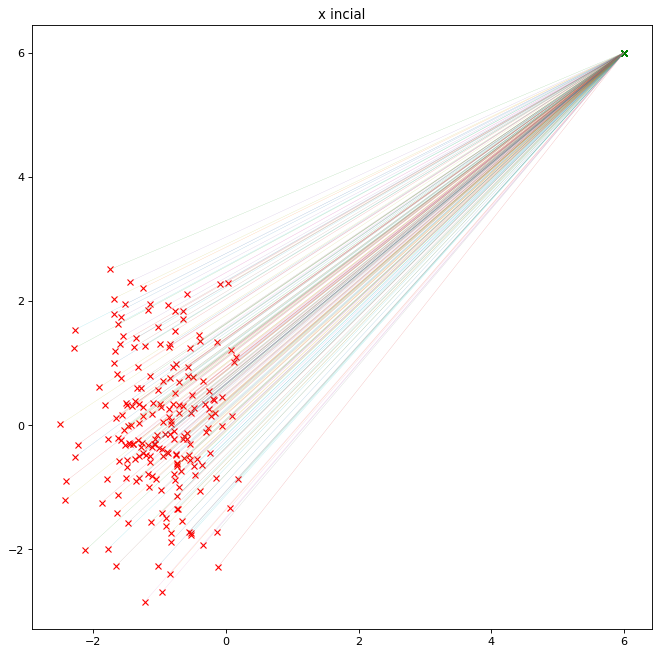

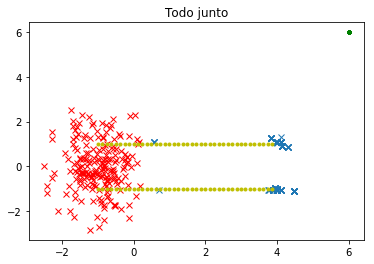

In [12]:
X_transported=res['x']
X_t=X_transported.reshape(-1,dimension)

percent=0.9

from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')



x=X_t[:,0]
y=X_t[:,1]
plt.plot(x,y,'x')
plt.plot(x1,x2,'x',c='r')
#plt.plot(y1,y2,'.',c='g')
for i in range(int(len(x)*percent)):
    plt.plot([x1[i],x[i]],[x2[i],y[i]],lw=0.1)
plt.title('x optimizado')
plt.show()
#plt.plot([2,1],[4,4])


figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

inicial=xinit.reshape(-1,dimension)
plt.plot(x1,x2,'x',c='r')
plt.plot(inicial[:,0],inicial[:,1],'x',c='g')
for i in range(int(len(x)*percent)):
    plt.plot([x1[i],inicial[i,0]],[x2[i],inicial[i,1]],lw=0.1)

plt.title('x incial')
plt.show()



plt.plot(x,y,'x')
plt.plot(x1,x2,'x',c='r')
plt.plot(inicial[:,0],inicial[:,1],'.',c='g')
plt.plot(top[:,0],top[:,1],'.',c='y')
plt.plot(bottom[:,0],bottom[:,1],'.',c='y')
plt.title('Todo junto')
plt.show()

## Trato ahora de poner Kernels como feature functions porque se me colapsa en pocos puntos

In [11]:
A=np.zeros((dimension,dimension*puntos))

aux0=np.tile([1,0],puntos)
aux1=np.tile([0,1],puntos)
A[0,:]=aux0
A[1,:]=aux1

A=A/puntos
b=np.mean(Ycol,axis=0)

#RESTRICCIONES DE IGUALDAD
con1 = lambda x: np.dot(A[1,:], x) - b[1]
con0 = lambda x: np.dot(A[0,:], x ) - b[0]

A00 =  np.kron(np.eye(puntos),np.array([[1,0],[0,0]]))/puntos 
A01 =  np.kron(np.eye(puntos),np.array([[0,1],[0,0]]))/puntos 
A11 =  np.kron(np.eye(puntos),np.array([[0,0],[0,1]]))/puntos 


def con00(x):
    return (x@A00@x.T - Y@A00@Y.T ) 

def con01(x):
    return (x@A01@x.T - Y@A01@Y.T )                 
   
def con11(x):
    return (x@A11@x.T - Y@A11@Y.T )


cons = [{'type': 'eq', 'fun': con0,'jac': lambda x: A[0,:]},
        {'type': 'eq', 'fun': con1,'jac': lambda x: A[1,:]},
        {'type': 'eq', 'fun': con00,'jac': lambda x: 2*A00@x.T},
        {'type': 'eq', 'fun': con01,'jac': lambda x: 2*A01@x.T},
        {'type': 'eq', 'fun': con11,'jac': lambda x: 2*A11@x.T} ]


#LINEAR CONSTRAINTS
#eps=0.1*np.ones(b.shape)
#cons = LinearConstraint(A,b-eps,b+eps)
#cons=LinearConstraint(A,b,b)

#XINICIAL, QUE VA
xinit = Y

#ACA PUEDO PONER OPCIONES
opt={"disp": True, "maxiter":500}

In [12]:
#Primero elijo los centros de los kernels
centros=(np.random.random((puntos//5,dimension))*2-1) 
centros[:,0]=centros[:,0]/2
centros+= [4,0]

In [13]:
#El kernel
def kernel(x,centro,h):
    xposta=x.reshape(-1,dimension)
    enX= np.mean( [  np.exp( -np.linalg.norm(xposta[i,:]-centro)**2/(2*(h**2)) )/np.sqrt((2*np.pi)**dimension) for i in range(xposta.shape[0])] ) 
    enY= np.mean( [  np.exp( -np.linalg.norm(Ycol[i,:]-centro)**2/(2*(h**2)) )/np.sqrt((2*np.pi)**dimension) for i in range(Ycol.shape[0])] )
    return (enX-enY)
    
def jac(x,centro,h):
    grad=np.ones(x.shape)
    xposta=x.reshape(-1,dimension)
    for i in range(xposta.shape[0]):
        aux=np.exp( -np.linalg.norm(xposta[i,:]-centro)**2/(2*(h**2)) )/( np.sqrt((2*np.pi)**dimension) * (h**2))
        
        #aux=1 #PONGO ESTO PARA QUE EL GRADIENTE NO SE ANULE LEJOS!
        
        g_loc=-(xposta[i,:]-centro) * aux
        for coordenada in range(dimension):
            grad[dimension*i+coordenada]= g_loc[coordenada]
    return grad/puntos

#UN KERNEL GAUSSIANO TIENE GRADIENTE 0 EN MUCHOS LADOS Y ME TIRA QUE LA MATRIZ SE HACE SINGULAR
def kernel2(x,centro,h):
    xposta=x.reshape(-1,dimension)
    enX= np.mean( [  np.linalg.norm(xposta[i,:]-centro)**2/((h**2))  for i in range(xposta.shape[0])] ) 
    enY= np.mean( [  np.linalg.norm(Ycol[i,:]-centro)**2/((h**2))  for i in range(Ycol.shape[0])] )
    return (enX-enY)

def jac2(x,centro,h):
    grad=np.ones(x.shape)
    xposta=x.reshape(-1,dimension)
    for i in range(xposta.shape[0]):
        aux=2/(h**2)
        g_loc=(xposta[i,:]-centro) * aux
        for coordenada in range(dimension):
            grad[dimension*i+coordenada]= g_loc[coordenada]
    return grad/puntos



h_fijo=100
for i in range(centros.shape[0]):
    centro=centros[i,:]
    cons.append({'type':'eq', 'fun': lambda x: kernel(x,centro,h_fijo), 'jac': lambda x: jac(x,centro,h_fijo)}  )
    #cons.append({'type':'eq', 'fun': lambda x: kernel2(x,centro,h_fijo), 'jac': lambda x: jac2(x,centro,h_fijo)}  )


In [14]:
%%time
Nfeval=1
def callbackF(Xi,d):
    global Nfeval
    print ('Iteracion:'+ str(Nfeval)+',    f: '+str(costo_sin_x(Xi)[0]) )
    Nfeval += 1
    
    
xinit=np.random.random(Y.shape)
xinit=Z

opt={"disp": True, "maxiter":100}

res = minimize(costo_sin_x, x0=xinit,jac=True,constraints=cons,method='trust-constr',options=opt,callback=callbackF)
print(res)

/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:1,    f: 0.0


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:2,    f: 0.6323426976353886


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:3,    f: 18.800632619641984


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:4,    f: 533.9940225862808


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:5,    f: 533.9940225862808


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:6,    f: 1034.496954887305


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:7,    f: 1034.496954887305


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:8,    f: 926.0361191780211


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:9,    f: 926.0361191780211


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:10,    f: 903.9711166595557


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:11,    f: 903.9711166595557


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:12,    f: 882.0847216576101


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:13,    f: 882.0847216576101


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:14,    f: 882.601919268715


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:15,    f: 882.601919268715


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:16,    f: 752.122889049488


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:17,    f: 752.122889049488


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:18,    f: 714.4116305198701


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:19,    f: 714.4116305198701


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:20,    f: 609.7076917520236


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:21,    f: 609.7076917520236


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:22,    f: 611.6781638466763


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:23,    f: 611.6781638466763


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:24,    f: 521.5234715705747


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:25,    f: 521.5234715705747


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:26,    f: 439.74398280653435


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:27,    f: 439.74398280653435


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:28,    f: 454.69375551824123


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:29,    f: 454.69375551824123


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:30,    f: 424.1193857866063


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:31,    f: 424.1193857866063


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:32,    f: 385.5063577703522


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:33,    f: 385.5063577703522


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:34,    f: 389.34963919292954


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:35,    f: 398.94623759325737


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:36,    f: 398.94623759325737


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:37,    f: 348.13833619998877


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:38,    f: 336.22062462706737


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:39,    f: 315.1474399427711


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:40,    f: 315.1474399427711


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:41,    f: 256.1300393210779


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:42,    f: 256.1300393210779


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:43,    f: 221.90245029729493


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:44,    f: 221.90245029729493


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:45,    f: 199.27529139745533


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:46,    f: 199.27529139745533


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:47,    f: 179.23751755104266


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:48,    f: 175.3875926414716


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:49,    f: 169.27775199660192


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:50,    f: 169.27775199660192


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:51,    f: 167.85693613197574


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:52,    f: 167.85693613197574


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:53,    f: 169.4736868165666


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:54,    f: 168.20663789020523


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:55,    f: 167.5517708689613


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:56,    f: 167.30851830242503


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:57,    f: 167.30851830242503


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:58,    f: 167.07053829786634


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:59,    f: 167.07053829786634


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:60,    f: 166.93002316127868


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:61,    f: 166.7431117919321


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:62,    f: 166.7431117919321


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:63,    f: 166.66492780569448


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:64,    f: 166.58448432379421


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:65,    f: 166.50544749985147


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:66,    f: 166.42448226906907


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:67,    f: 166.3430646589183


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:68,    f: 166.26275684062162


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:69,    f: 166.18260364386566


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:70,    f: 166.1034700687369


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:71,    f: 166.02553174547018


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:72,    f: 165.94866601043873


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:73,    f: 165.87221977118563


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:74,    f: 165.79704773894073


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:75,    f: 165.71719611357466


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:76,    f: 165.63925716500154


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:77,    f: 165.5601979479886


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:78,    f: 165.48333265194063


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:79,    f: 165.40550360403725


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:80,    f: 165.33058550323494


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:81,    f: 165.2556098047798


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:82,    f: 165.18281643114844


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:83,    f: 165.10942987636736


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:84,    f: 165.0387321759244


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:85,    f: 164.96763509668756


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:86,    f: 164.89779989819598


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:87,    f: 164.8240315279721


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:88,    f: 164.75200172459571


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:89,    f: 164.69394484662504


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:90,    f: 164.69394484662504


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:91,    f: 164.66236122824174


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:92,    f: 164.6177589200786


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iteracion:93,    f: 164.6177589200786


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:94,    f: 164.59965104646406


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:95,    f: 164.58106452270604


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:96,    f: 164.56313967746658


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:97,    f: 164.544846462818


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:98,    f: 164.527075214682


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:99,    f: 164.5089788006289


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:100,    f: 164.49140630672684


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


Iteracion:101,    f: 164.47350733297878
The maximum number of function evaluations is exceeded.
Number of iterations: 101, function evaluations: 148, CG iterations: 283, optimality: 1.21e+00, constraint violation: 3.66e-05, execution time: 1.3e+03 s.
         cg_niter: 283
     cg_stop_cond: 2
           constr: [array([0.]), array([0.]), array([2.5628708e-09]), array([-3.65790891e-05]), array([6.82789381e-11]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08999484e-14]), array([-2.08

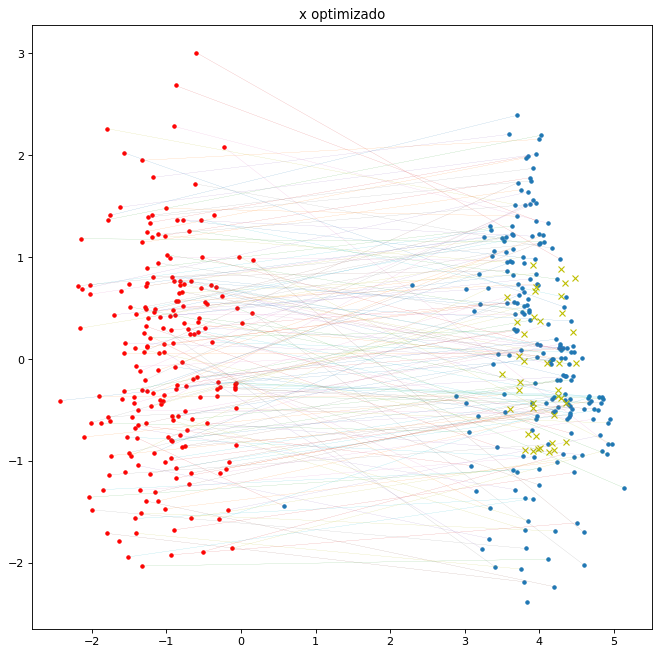

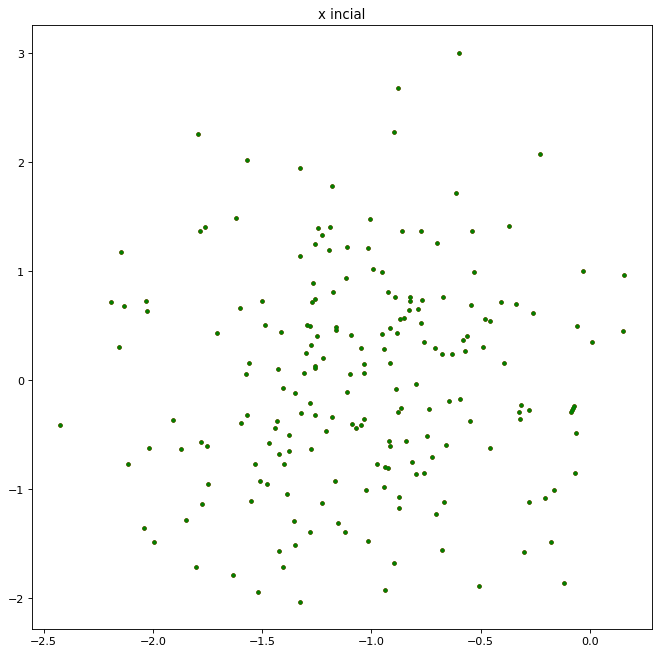

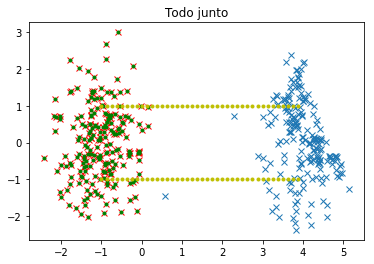

In [15]:
X_transported=res['x']
X_t=X_transported.reshape(-1,dimension)

percent=0.9

from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')



x=X_t[:,0]
y=X_t[:,1]
plt.plot(x,y,'.')
plt.plot(x1,x2,'.',c='r')
plt.plot(centros[:,0],centros[:,1],'x',c='y')
for i in range(int(len(x)*percent)):
    plt.plot([x1[i],x[i]],[x2[i],y[i]],lw=0.1)
plt.title('x optimizado')
plt.show()
#plt.plot([2,1],[4,4])


figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

inicial=xinit.reshape(-1,dimension)
plt.plot(x1,x2,'.',c='r')
plt.plot(inicial[:,0],inicial[:,1],'.',c='g')
for i in range(int(len(x)*percent)):
    plt.plot([x1[i],inicial[i,0]],[x2[i],inicial[i,1]],lw=0.1)

plt.title('x incial')
plt.show()



plt.plot(x,y,'x')
plt.plot(x1,x2,'x',c='r')
plt.plot(inicial[:,0],inicial[:,1],'.',c='g')
plt.plot(top[:,0],top[:,1],'.',c='y')
plt.plot(bottom[:,0],bottom[:,1],'.',c='y')
plt.title('Todo junto')
plt.show()

In [16]:
max([con['fun'](X_transported) for con in cons])

2.5628708044678206e-09

# Probandoo Baricentro

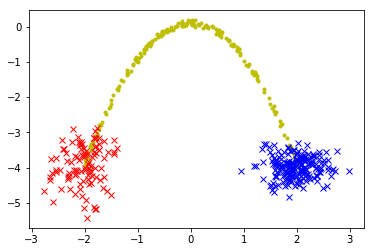

In [45]:
puntos=200
x=(np.random.random(puntos)*4-2).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.2*np.random.random(puntos).reshape(-1,1)
W=np.concatenate((x,y),axis=1)




y1, y2 = np.random.multivariate_normal([2,-4], [[0.1,0],[0,0.1]], puntos).T
y1=np.array(y1)
y2=np.array(y2)
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)

Ycol=np.concatenate((y1,y2),axis=1)
Y=Ycol.flatten()


x1, x2 = np.random.multivariate_normal([-2,-4], [[0.1,0],[0,0.3]], puntos//2).T
x1=np.array(x1)
x2=np.array(x2)
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)
Zcol=np.concatenate((x1,x2),axis=1)
Z=Zcol.flatten()





plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'x',c='r')
plt.plot(y1,y2,'x',c='b')

In [46]:
dimension=2 

alphaESP=2
kESP=10#cuanos vecinos miro para decidir la distancia a la que esta el nuevo punto
        
dataESP=np.concatenate((Zcol,Ycol,W),axis=0)
distanciasESP=np.matrix(distance_matrix(dataESP,dataESP))

modelESP=F.Fermat(alphaESP, path_method='FW')
modelESP.fit(distanciasESP)
distESP=modelESP.get_distances()
treeESP = KDTree(dataESP, leaf_size=2)

def costo_sin_x(x):
    
    xposta=x.reshape(x.shape[0]//dimension,dimension)
     
    res=0
    gradient=np.ones(x.shape)
    for i in range(Zcol.shape[0]):
        aux,grad_idx=distanciaFermat(i,xposta[i,:],distESP,treeESP,kESP) 
        res+=aux
        
        q=dataESP[grad_idx,:] #el ultimo mas cercano en el "mejor camino"
        grad=alphaESP*(np.linalg.norm(q-xposta[i,:])**(alphaESP-2))*(xposta[i,:]-q) #EL gradiente
        
        for coordenada in range(dimension):
            gradient[dimension*i+coordenada]=grad[coordenada]
    return res,gradient



def distanciaFermat(idx,end,dist,tree,k):
    d,ind=tree.query([end],k=k)
    d=np.power(d,alphaESP)
    ret=min([ dist[idx,ind[0,i]]+d[0,i] for i in range(d.shape[1])])
    
    indice=np.argmin([ dist[idx,ind[0,i]] for i in range(ind.shape[1])]) 
    
    grad_idx=ind[0,indice] #DEVUELVE EL INDICE DEL VECINO que esta a menor dist_fer de idx
    
    return ret,grad_idx



def costo_sin_x_ni_grad(x):
    
    xposta=x.reshape(x.shape[0]//dimension,dimension)
     
    res=0
    for i in range(Zcol.shape[0]):
        aux,grad_idx=distanciaFermat(i,xposta[i,:],distESP,treeESP,kESP) 
        res+=aux
    return res

In [11]:
A=np.zeros((dimension,dimension*puntos))

aux0=np.tile([1,0],puntos)
aux1=np.tile([0,1],puntos)
A[0,:]=aux0
A[1,:]=aux1

A=A/puntos
b=np.mean(Ycol,axis=0)

#RESTRICCIONES DE IGUALDAD
con1 = lambda x: np.dot(A[1,:], x) - b[1]
con0 = lambda x: np.dot(A[0,:], x ) - b[0]

A00 =  np.kron(np.eye(puntos),np.array([[1,0],[0,0]]))/puntos 
A01 =  np.kron(np.eye(puntos),np.array([[0,1],[0,0]]))/puntos 
A11 =  np.kron(np.eye(puntos),np.array([[0,0],[0,1]]))/puntos 


def con00(x):
    return (x@A00@x.T - Y@A00@Y.T ) 

def con01(x):
    return (x@A01@x.T - Y@A01@Y.T )                 
   
def con11(x):
    return (x@A11@x.T - Y@A11@Y.T )


cons = [{'type': 'eq', 'fun': con0,'jac': lambda x: A[0,:]},
        {'type': 'eq', 'fun': con1,'jac': lambda x: A[1,:]},
        {'type': 'eq', 'fun': con00,'jac': lambda x: 2*A00@x.T},
        {'type': 'eq', 'fun': con01,'jac': lambda x: 2*A01@x.T},
        {'type': 'eq', 'fun': con11,'jac': lambda x: 2*A11@x.T} ]


#LINEAR CONSTRAINTS
#eps=0.1*np.ones(b.shape)
#cons = LinearConstraint(A,b-eps,b+eps)
#cons=LinearConstraint(A,b,b)

#XINICIAL, QUE VA
xinit = Y

#ACA PUEDO PONER OPCIONES
opt={"disp": True, "maxiter":500}